<a href="https://colab.research.google.com/github/marisolm3236/How-do-Holidays-Affect-Retail-Sales-/blob/master/retail_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retail Sales: Exploring the Relationship Between Holidays and Weekly Sales

Our overall goal for this project is to explore the relationship between the columns `IsHoliday` and `Weekly_Sales`. Moreover, we were interested in seeing how `Store`, `Dept`, `Type`, `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment` separately affected this relationship. We wanted to ask questions such as, "What will weekly sales look like if it's a holiday or not a holiday for each store or department?" We aimed to look for any trends and correlations between sales and holidays, and between sales and holidays given a third variable.



# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/MATH_3439/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the Data

The three datasets provided represent historical sales information for stores located in different regions with each store containing different departments.

In [ ]:
df_sales = pd.read_csv(drive_dir + 'data/retail_sales/sales.csv')
df_sales.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-05-02      24924.50      False
1      1     1  2010-12-02      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-05-03      21827.90      False

In [ ]:
df_store_feat = pd.read_csv(drive_dir + 'data/retail_sales/store_features.csv')
df_store_feat.head()

Store        Date  Temperature  ...         CPI  Unemployment  IsHoliday
0      1  05/02/2010        42.31  ...  211.096358         8.106      False
1      1  12/02/2010        38.51  ...  211.242170         8.106       True
2      1  19/02/2010        39.93  ...  211.289143         8.106      False
3      1  26/02/2010        46.63  ...  211.319643         8.106      False
4      1  05/03/2010        46.50  ...  211.350143         8.106      False

[5 rows x 12 columns]

In [ ]:
df_stores = pd.read_csv(drive_dir + 'data/retail_sales/stores.csv')
df_stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

# Describing the Data

## Sales Dataset:

In this section we found out the basics of our sales dataset. This includes: the size or shape of the dataset, the time interval, min and max of sales and other information about the data.

This dataset has 5 columns and 140679 rows.

In [ ]:
df_sales.shape

(140679, 5)

There are 45 unique stores and 81 unique departments.

In [ ]:
df_sales['Store'].nunique()

45

In [ ]:
df_sales['Dept'].nunique()

81

Here we look at the datatypes of each column to see if there needs to be any changes made.

In [ ]:
df_sales.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

We see that `Date` is an object, so we change this to a datetime.

In [ ]:
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

In [ ]:
df_sales.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

There are 48 unique dates, ranging from 01-10-2010 to 12-31-2010.

In [ ]:
len(df_sales['Date'].unique())

48

In [ ]:
df_sales['Date'].min()

Timestamp('2010-01-10 00:00:00')

In [ ]:
df_sales['Date'].max()

Timestamp('2010-12-31 00:00:00')

We used `.describe()` to find the count, mean, std, min, max, and quartiles. We did find it intersting that our minimum was negative.

In [ ]:
df_sales['Weekly_Sales'].describe()

count    140679.000000
mean      16270.275737
std       23063.221134
min       -4988.940000
25%        2238.330000
50%        7964.300000
75%       20587.205000
max      693099.360000
Name: Weekly_Sales, dtype: float64

We were intrigued by the negative value for weekly sales, so we decided to dig deeper.

In [ ]:
df_neg_sales = df_sales[df_sales['Weekly_Sales']<0]
df_neg_sales['Store'].nunique()

45

In [ ]:
df_neg_sales.shape

(390, 5)

In [ ]:
df_neg_sales['Store'].value_counts()

35    24
17    20
10    19
15    18
21    16
31    16
18    16
42    15
22    15
39    13
19    11
27    11
11    11
32    11
23    10
2     10
41    10
29     9
43     9
12     9
14     8
13     8
6      8
45     8
25     8
20     7
9      7
8      6
7      6
40     5
5      5
16     5
44     4
28     4
30     4
33     4
38     3
1      3
34     3
26     3
24     3
3      2
37     1
4      1
36     1
Name: Store, dtype: int64

We can see all 45 stores reported negative sales, with some stores reporting negative weekly sales multiple weeks. We conclude that this is not a mistake in the data, but intentional. We can hypothesize right now what these negative values mean. It could possibly be due to theft, returns, extreme couponing, etc.

As we can see, there are 128905 False values and 11774 True values for `IsHoliday`. 

In [ ]:
df_sales['IsHoliday'].value_counts()

False    128905
True      11774
Name: IsHoliday, dtype: int64

We look at the missing values for each column.

In [ ]:
for col in df_sales.columns:
    print(f'{col}: {df_sales[col].isna().sum()} ({100 * df_sales[col].isna().sum() / df_sales.shape[0]}%)')

Store: 0 (0.0%)
Dept: 0 (0.0%)
Date: 0 (0.0%)
Weekly_Sales: 0 (0.0%)
IsHoliday: 0 (0.0%)


## Store Features Dataset:

The store features dataset has 12 columns and 8190 rows.

In [ ]:
df_store_feat.shape

(8190, 12)

There are 45 unique stores.

In [ ]:
df_store_feat['Store'].nunique()

45

We look at the datatypes for each column to see if there needs to be any changing.

In [ ]:
df_store_feat.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

Again, we changed the data type of `Date` from object to datetime.

In [ ]:
df_store_feat['Date'] = pd.to_datetime(df_store_feat['Date'])

In [ ]:
df_store_feat.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
dtype: object

There are 182 unique dates, ranging from 01-10-2010 to 12-07-2013.

In [ ]:
len(df_store_feat['Date'].unique())

182

In [ ]:
df_store_feat['Date'].min()

Timestamp('2010-01-10 00:00:00')

In [ ]:
df_store_feat['Date'].max()

Timestamp('2013-12-07 00:00:00')

We used `.describe()` to find out statistics on our columns in this dataset.

In [ ]:
df_store_feat['Temperature'].describe()

count    8190.000000
mean       59.356198
std        18.678607
min        -7.290000
25%        45.902500
50%        60.710000
75%        73.880000
max       101.950000
Name: Temperature, dtype: float64

In [ ]:
df_store_feat['Fuel_Price'].describe()

count    8190.000000
mean        3.405992
std         0.431337
min         2.472000
25%         3.041000
50%         3.513000
75%         3.743000
max         4.468000
Name: Fuel_Price, dtype: float64

We found it interesting that some of our values for the markdown columns are negative.

In [ ]:
df_store_feat['MarkDown1'].describe()

count      4032.000000
mean       7032.371786
std        9262.747448
min       -2781.450000
25%        1577.532500
50%        4743.580000
75%        8923.310000
max      103184.980000
Name: MarkDown1, dtype: float64

In [ ]:
df_store_feat['MarkDown2'].describe()

count      2921.000000
mean       3384.176594
std        8793.583016
min        -265.760000
25%          68.880000
50%         364.570000
75%        2153.350000
max      104519.540000
Name: MarkDown2, dtype: float64

In [ ]:
df_store_feat['MarkDown3'].describe()

count      3613.000000
mean       1760.100180
std       11276.462208
min        -179.260000
25%           6.600000
50%          36.260000
75%         163.150000
max      149483.310000
Name: MarkDown3, dtype: float64

In [ ]:
df_store_feat['MarkDown4'].describe()

count     3464.000000
mean      3292.935886
std       6792.329861
min          0.220000
25%        304.687500
50%       1176.425000
75%       3310.007500
max      67474.850000
Name: MarkDown4, dtype: float64

In [ ]:
df_store_feat['MarkDown5'].describe()

count      4050.000000
mean       4132.216422
std       13086.690278
min        -185.170000
25%        1440.827500
50%        2727.135000
75%        4832.555000
max      771448.100000
Name: MarkDown5, dtype: float64

We decided to explore these negative values here.

In [ ]:
neg_markdown_col = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5']

for col in neg_markdown_col:
  df_neg_md = df_store_feat[df_store_feat[col]<0]
  print(f'{col}:')
  print(f'shape: {df_neg_md.shape}')
  print(f"number of unique stores: {df_neg_md['Store'].nunique()}")
  print(f"store value counts: {df_neg_md['Store'].value_counts()}")

MarkDown1:
shape: (4, 12)
number of unique stores: 3
store value counts: 36    2
23    1
30    1
Name: Store, dtype: int64
MarkDown2:
shape: (25, 12)
number of unique stores: 20
store value counts: 41    2
5     2
9     2
15    2
10    2
31    1
12    1
35    1
4     1
7     1
11    1
13    1
25    1
14    1
16    1
18    1
19    1
20    1
24    1
34    1
Name: Store, dtype: int64
MarkDown3:
shape: (13, 12)
number of unique stores: 10
store value counts: 22    2
9     2
39    2
28    1
13    1
38    1
31    1
6     1
36    1
35    1
Name: Store, dtype: int64
MarkDown5:
shape: (2, 12)
number of unique stores: 2
store value counts: 5     1
32    1
Name: Store, dtype: int64


We can conclude it just wasn't the case where one or two stores are responsible for having negative values for markdowns. However, with these numbers and the differences between different markdowns, we think it is intential. It could be intentional because it is possible for a store to lose money during a sale.

In [ ]:
df_store_feat['CPI'].describe()

count    7605.000000
mean      172.460809
std        39.738346
min       126.064000
25%       132.364839
50%       182.764003
75%       213.932412
max       228.976456
Name: CPI, dtype: float64

In [ ]:
df_store_feat['Unemployment'].describe()

count    7605.000000
mean        7.826821
std         1.877259
min         3.684000
25%         6.634000
50%         7.806000
75%         8.567000
max        14.313000
Name: Unemployment, dtype: float64

We used value counts to determine how many False and True values we have for the `IsHoliday` column.

In [ ]:
df_store_feat['IsHoliday'].value_counts()

False    7605
True      585
Name: IsHoliday, dtype: int64

We look at missing values for all our columns in this dataset.

In [ ]:
for col in df_store_feat.columns:
    print(f'{col}: {df_store_feat[col].isna().sum()} ({100 * df_store_feat[col].isna().sum() / df_store_feat.shape[0]:.2f}%)')

Store: 0 (0.00%)
Date: 0 (0.00%)
Temperature: 0 (0.00%)
Fuel_Price: 0 (0.00%)
MarkDown1: 4158 (50.77%)
MarkDown2: 5269 (64.33%)
MarkDown3: 4577 (55.89%)
MarkDown4: 4726 (57.70%)
MarkDown5: 4140 (50.55%)
CPI: 585 (7.14%)
Unemployment: 585 (7.14%)
IsHoliday: 0 (0.00%)


## Stores Dataset:

The stores dataset has 3 comlumns and 45 rows.

In [ ]:
df_stores.shape

(45, 3)

Again, we see that there are 45 unique stores.

In [ ]:
df_stores['Store'].nunique()

45

We use value counts to determine the type of store and how often they occur in the dataset.

In [ ]:
df_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

We use `.describe()` to learn basic statistics of the size column.

In [ ]:
df_stores['Size'].describe()

count        45.000000
mean     130287.600000
std       63825.271991
min       34875.000000
25%       70713.000000
50%      126512.000000
75%      202307.000000
max      219622.000000
Name: Size, dtype: float64

We look at missing values for all columns in this dataset.

In [ ]:
for col in df_stores.columns:
    print(f'{col}: {df_stores[col].isna().sum()} ({100 * df_stores[col].isna().sum() / df_stores.shape[0]:.2f}%)')

Store: 0 (0.00%)
Type: 0 (0.00%)
Size: 0 (0.00%)


# Merging the Data

We decided to merge the three datasets together to have all the data in one place. This will make the analysis easier down the road.

First we found the data types for df_sales and df_store_feat.

In [ ]:
df_sales.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [ ]:
df_store_feat.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
dtype: object

We used `pd.merge()` to merge df_sales and df_store_feat. We did this using a left join to produce a complete set of records from df_sales, with the matching records (where available) in df_store_feat. We merged on the three columns listed below because we wanted matching records based on date, store, and whether or not it was a holiday. This is because we wanted to keep all 'Weekly_Sales` information because that is what we are analyzing.

In [ ]:
df_merged = pd.merge(df_sales, df_store_feat, on=['Date', 'Store', 'IsHoliday'], how='left')

We then used `pd.merge()` again to merge our first joined dataframe and df_stores. We did this using a left join again based on the `Store` column.


In [ ]:
df_merged = pd.merge(df_merged, df_stores, on='Store', how='left')

In [ ]:
df_merged.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1 2010-05-02      24924.50  ...  211.096358         8.106     A  151315
1      1     1 2010-12-02      46039.49  ...  211.242170         8.106     A  151315
2      1     1 2010-02-19      41595.55  ...  211.289143         8.106     A  151315
3      1     1 2010-02-26      19403.54  ...  211.319643         8.106     A  151315
4      1     1 2010-05-03      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 16 columns]

In [ ]:
df_merged.shape

(140679, 16)

# Describing the Merged Data

We decided to describe our data again to make sure our data makes sense and to gain a better understanding of our joined dataset.

In [ ]:
df_merged.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [ ]:
df_merged['IsHoliday'].value_counts()

False    128905
True      11774
Name: IsHoliday, dtype: int64

In [ ]:
df_merged['Weekly_Sales'].describe()

count    140679.000000
mean      16270.275737
std       23063.221134
min       -4988.940000
25%        2238.330000
50%        7964.300000
75%       20587.205000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [ ]:
df_merged.shape

(140679, 16)

In [ ]:
df_merged[df_merged['IsHoliday']==True].head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
1       1     1 2010-12-02      46039.49  ...  211.242170         8.106     A  151315
31      1     1 2010-10-09      18194.74  ...  211.495190         7.787     A  151315
42      1     1 2010-11-26      18820.29  ...  211.748433         7.838     A  151315
47      1     1 2010-12-31      19124.58  ...  211.404932         7.838     A  151315
49      1     2 2010-12-02      44682.74  ...  211.242170         8.106     A  151315

[5 rows x 16 columns]

In [ ]:
df_merged[df_merged['IsHoliday']==False].head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1 2010-05-02      24924.50  ...  211.096358         8.106     A  151315
2      1     1 2010-02-19      41595.55  ...  211.289143         8.106     A  151315
3      1     1 2010-02-26      19403.54  ...  211.319643         8.106     A  151315
4      1     1 2010-05-03      21827.90  ...  211.350143         8.106     A  151315
5      1     1 2010-12-03      21043.39  ...  211.380643         8.106     A  151315

[5 rows x 16 columns]

In [ ]:
df_merged['Date'].min()

Timestamp('2010-01-10 00:00:00')

In [ ]:
df_merged['Date'].max()

Timestamp('2010-12-31 00:00:00')

We were interested in seeing if stores varied in how many departments they had.

In [ ]:
store_dept = {}

for name, group in df_merged.groupby('Store'):
  store_dept[name] = group['Dept'].nunique()

store_dept

{1: 76,
 2: 77,
 3: 69,
 4: 77,
 5: 70,
 6: 75,
 7: 73,
 8: 73,
 9: 69,
 10: 76,
 11: 76,
 12: 72,
 13: 76,
 14: 75,
 15: 75,
 16: 70,
 17: 73,
 18: 76,
 19: 77,
 20: 76,
 21: 73,
 22: 74,
 23: 74,
 24: 76,
 25: 74,
 26: 73,
 27: 77,
 28: 76,
 29: 72,
 30: 60,
 31: 75,
 32: 76,
 33: 54,
 34: 77,
 35: 72,
 36: 57,
 37: 56,
 38: 60,
 39: 74,
 40: 75,
 41: 74,
 42: 55,
 43: 56,
 44: 54,
 45: 72}

We can see that different stores have a different number of departments, but most stores fall within the area of the 70-something different departments.

We are also interested in seeing when different stores report their weekly sales. We created a new column with the day of the week and see if this differed.

In [ ]:
df_merged['day of week'] = df_merged['Date'].dt.day_name()

In [ ]:
store_day = {}

for store, group in df_merged.groupby('Store'):
  store_day[store] = group['day of week'].unique()

store_day

{1: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 2: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 3: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 4: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 5: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 6: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 7: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 8: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 9: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 10: array(['Sunday', 'Thursday', 'Friday', 'Monday', 'Saturday', 'Tuesday'],
       dtype=object),
 11: arra

We can see that all 45 stores reported their weekly sales on every day of the week except Wednesday. We then wanted to check how many dates were reported for each store and if this varied or not.

In [ ]:
store_dept = {}

for name, group in df_merged.groupby('Store'):
  store_dept[name] = group['Date'].nunique()

store_dept

{1: 48,
 2: 48,
 3: 48,
 4: 48,
 5: 48,
 6: 48,
 7: 48,
 8: 48,
 9: 48,
 10: 48,
 11: 48,
 12: 48,
 13: 48,
 14: 48,
 15: 48,
 16: 48,
 17: 48,
 18: 48,
 19: 48,
 20: 48,
 21: 48,
 22: 48,
 23: 48,
 24: 48,
 25: 48,
 26: 48,
 27: 48,
 28: 48,
 29: 48,
 30: 48,
 31: 48,
 32: 48,
 33: 48,
 34: 48,
 35: 48,
 36: 48,
 37: 48,
 38: 48,
 39: 48,
 40: 48,
 41: 48,
 42: 48,
 43: 48,
 44: 48,
 45: 48}

All 45 stores reported weekly sales on 48 unique dates each. We then checked if each store reported their sales on the same week number of the year.

In [ ]:
df_merged['Week_Number'] = df_merged['Date'].dt.week

In [ ]:
df_merged['Week_Number'].nunique()

41

In [ ]:
store_week = {}

for name, group in df_merged.groupby('Store'):
  store_week[name] = group['Week_Number'].unique()
  
store_week

{1: array([17, 48,  7,  8, 18, 11, 12,  5, 35, 15, 16, 27, 19, 20, 21, 14, 44,
        24, 25, 36, 28, 29, 30, 23, 32, 33, 34, 10, 40, 37, 38,  1, 41, 42,
        43, 49, 46, 47, 50, 51, 52]),
 2: array([17, 48,  7,  8, 18, 11, 12,  5, 35, 15, 16, 27, 19, 20, 21, 14, 44,
        24, 25, 36, 28, 29, 30, 23, 32, 33, 34, 10, 40, 37, 38,  1, 41, 42,
        43, 49, 46, 47, 50, 51, 52]),
 3: array([17, 48,  7,  8, 18, 11, 12,  5, 35, 15, 16, 27, 19, 20, 21, 14, 44,
        24, 25, 36, 28, 29, 30, 23, 32, 33, 34, 10, 40, 37, 38,  1, 41, 42,
        43, 49, 46, 47, 50, 51, 52]),
 4: array([17, 48,  7,  8, 18, 11, 12,  5, 35, 15, 16, 27, 19, 20, 21, 14, 44,
        24, 25, 36, 28, 29, 30, 23, 32, 33, 34, 10, 40, 37, 38,  1, 41, 42,
        43, 49, 46, 47, 50, 51, 52]),
 5: array([17, 48,  7,  8, 18, 11, 12,  5, 35, 15, 16, 27, 19, 20, 21, 14, 44,
        24, 25, 36, 28, 29, 30, 23, 32, 33, 34, 10, 40, 37, 38,  1, 41, 42,
        43, 49, 46, 47, 50, 51, 52]),
 6: array([17, 48,  7,  8, 18, 11, 

We found that all 45 stores reported weekly sales on the same week numbers of the year. From all this information, we can conclude that the stores reported their sales on the same weeks of the year, but different days of the week.

Next, we wanted to see what the variable `Type` meant. We create a function to make boxplots.

In [ ]:
def make_boxplot(x, y, title):
  fig, ax = plt.subplots(figsize=(15, 8))
  fig = sns.boxplot(x=x, y=y, data=df_merged, showfliers=False).set_title(title)

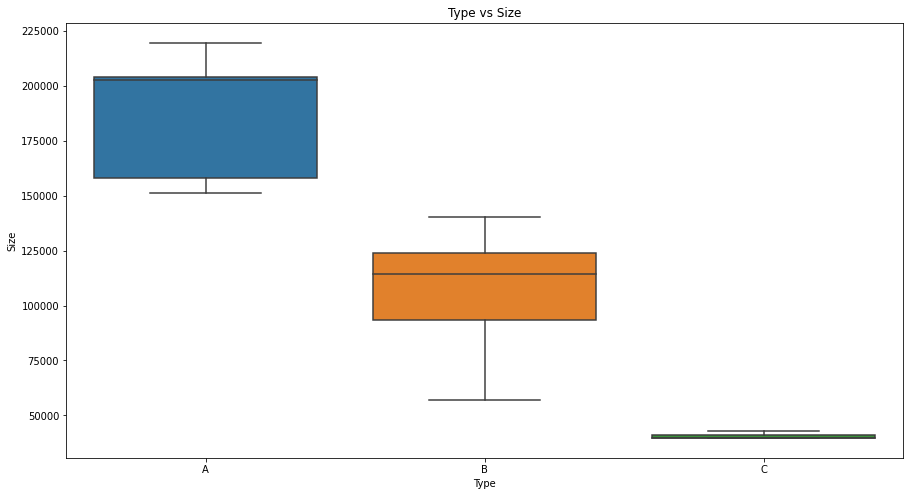

In [ ]:
make_boxplot(x='Type', y='Size', title='Type vs Size')

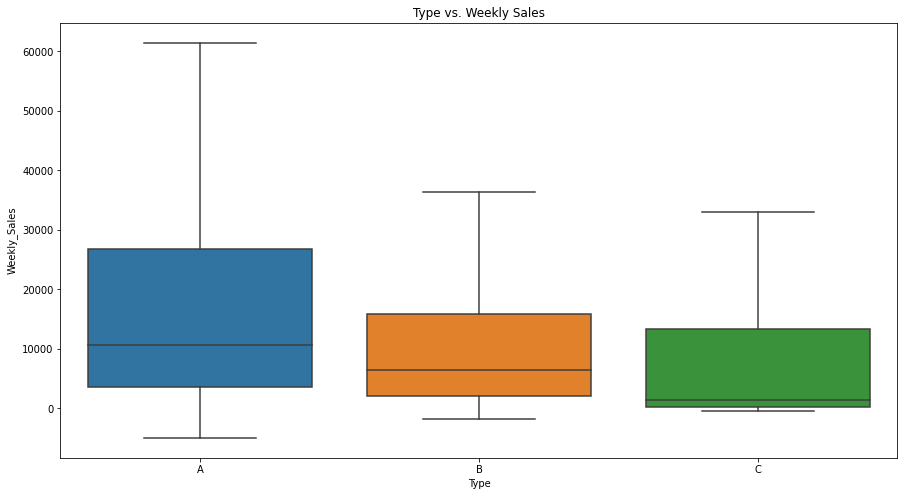

In [ ]:
make_boxplot(x='Type', y='Weekly_Sales', title='Type vs. Weekly Sales')

We can conclude that type is related to size with type A being of the largest size and type C being of the smallest size. Type A also had the highest median sales and type C has the least median sales.

# Cleaning the Data

We looked at the datatypes again just to double check everything makes sense.

In [ ]:
df_merged.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
day of week             object
Week_Number              int64
dtype: object

We look at missing values for each column.

In [ ]:
for col in df_merged.columns:
    print(f'{col}: {df_merged[col].isna().sum()} ({100 * df_merged[col].isna().sum() / df_merged.shape[0]:.2f}%)')

Store: 0 (0.00%)
Dept: 0 (0.00%)
Date: 0 (0.00%)
Weekly_Sales: 0 (0.00%)
IsHoliday: 0 (0.00%)
Temperature: 0 (0.00%)
Fuel_Price: 0 (0.00%)
MarkDown1: 140679 (100.00%)
MarkDown2: 140679 (100.00%)
MarkDown3: 140679 (100.00%)
MarkDown4: 140679 (100.00%)
MarkDown5: 140679 (100.00%)
CPI: 0 (0.00%)
Unemployment: 0 (0.00%)
Type: 0 (0.00%)
Size: 0 (0.00%)
day of week: 0 (0.00%)
Week_Number: 0 (0.00%)


In [ ]:
df_md = df_store_feat[df_store_feat['MarkDown1'].notnull()]
df_md['Date'].describe()

count                    4032
unique                     90
top       2012-08-24 00:00:00
freq                       45
first     2011-02-12 00:00:00
last      2013-12-07 00:00:00
Name: Date, dtype: object

In [ ]:
df_md = df_store_feat[df_store_feat['MarkDown2'].notnull()]
df_md['Date'].describe()

count                    2921
unique                     83
top       2013-01-02 00:00:00
freq                       45
first     2011-02-12 00:00:00
last      2013-12-07 00:00:00
Name: Date, dtype: object

In [ ]:
df_md = df_store_feat[df_store_feat['MarkDown3'].notnull()]
df_md['Date'].describe()

count                    3613
unique                     90
top       2012-07-13 00:00:00
freq                       45
first     2011-02-12 00:00:00
last      2013-12-07 00:00:00
Name: Date, dtype: object

In [ ]:
df_md = df_store_feat[df_store_feat['MarkDown4'].notnull()]
df_md['Date'].describe()

count                    3464
unique                     90
top       2011-12-30 00:00:00
freq                       45
first     2011-02-12 00:00:00
last      2013-12-07 00:00:00
Name: Date, dtype: object

In [ ]:
df_md = df_store_feat[df_store_feat['MarkDown5'].notnull()]
df_md['Date'].describe()

count                    4050
unique                     90
top       2012-08-24 00:00:00
freq                       45
first     2011-02-12 00:00:00
last      2013-12-07 00:00:00
Name: Date, dtype: object

This makes sense that we have 100% missing values for the markdown columns. Our merged data is only for 2010 and markdown information is only available starting in 2011. We drop Markdowns 1-5 because all values are missing, so these columns are useless in our analysis.

In [ ]:
df_merged = df_merged.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis='columns')

In [ ]:
for col in df_merged.columns:
    print(f'{col}: {df_merged[col].isna().sum()} ({100 * df_merged[col].isna().sum() / df_merged.shape[0]}%)')

Store: 0 (0.0%)
Dept: 0 (0.0%)
Date: 0 (0.0%)
Weekly_Sales: 0 (0.0%)
IsHoliday: 0 (0.0%)
Temperature: 0 (0.0%)
Fuel_Price: 0 (0.0%)
CPI: 0 (0.0%)
Unemployment: 0 (0.0%)
Type: 0 (0.0%)
Size: 0 (0.0%)
day of week: 0 (0.0%)
Week_Number: 0 (0.0%)


# Looking at IsHoliday and Assigning Our Own Holidays

We use the groupby function to group the data according to whether or not it is a holiday and get the values' corresponding median weekly sales. We used the median because the median is more robust to potential outliers.

In [ ]:
total_sales_by_holiday_df = df_merged.groupby('IsHoliday')['Weekly_Sales'].median()
total_sales_by_holiday_df

IsHoliday
False    7961.40
True     7995.04
Name: Weekly_Sales, dtype: float64

We create a bar chart for whether or not it is a holiday vs. median weekly sales.

Text(0, 0.5, 'Median Weekly Sales')

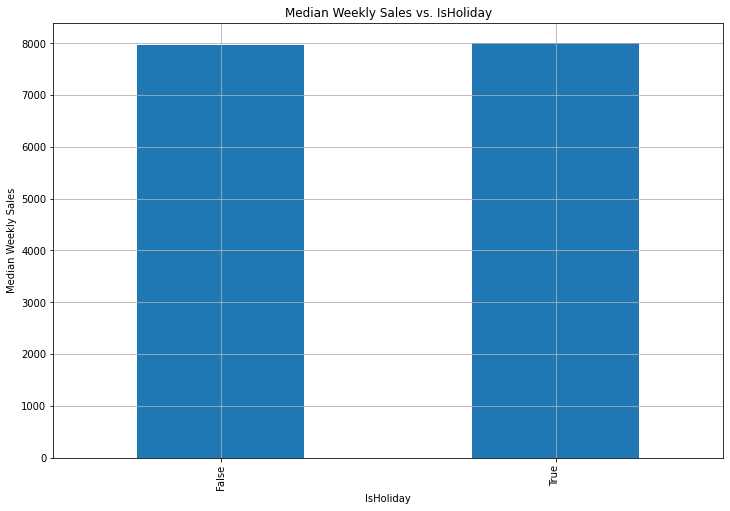

In [ ]:
ax_totalsales = total_sales_by_holiday_df.plot(kind='bar', grid=True, title='Median Weekly Sales vs. IsHoliday', figsize=(12,8))
ax_totalsales.set_ylabel('Median Weekly Sales')

As we can see in the graph above, there isn't really a difference in median weekly sales based on whether or not it is a holiday in this dataset. We want to see what the actual holiday dates are.

In [ ]:
df_isholiday = df_merged[df_merged['IsHoliday']==True]

In [ ]:
df_isholiday.shape

(11774, 13)

We use value counts to see what dates are considered holidays in the dataset.

In [ ]:
df_isholiday['Date'].unique()

array(['2010-12-02T00:00:00.000000000', '2010-10-09T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

As we can see, there are only 4 dates that are considered holidays, namely October 9, November 26, December 2, and December 31.

In [ ]:
df_isnotholiday = df_merged[df_merged['IsHoliday']==False]

In [ ]:
df_isnotholiday.head()

Store  Dept       Date  Weekly_Sales  ...  Type    Size  day of week  Week_Number
0      1     1 2010-05-02      24924.50  ...     A  151315       Sunday           17
2      1     1 2010-02-19      41595.55  ...     A  151315       Friday            7
3      1     1 2010-02-26      19403.54  ...     A  151315       Friday            8
4      1     1 2010-05-03      21827.90  ...     A  151315       Monday           18
5      1     1 2010-12-03      21043.39  ...     A  151315       Friday           48

[5 rows x 13 columns]

In [ ]:
df_isnotholiday['Date'].nunique()

44

In [ ]:
df_merged['Date'].nunique()

48

Below is a line graph of median weekly sales plotted against the date. The vertical black bars indicate the holiday weeks.

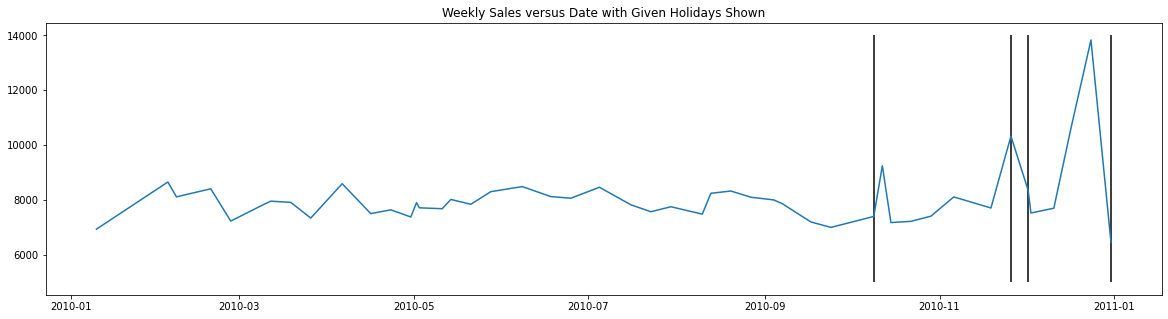

In [ ]:
#groupby date
df_average_sales_week2 = df_merged.groupby(by=['Date'], as_index=False)['Weekly_Sales'].median()

#plotting
plt.figure(figsize=(20,5))
#date vs. sales
plt.plot(df_average_sales_week2.Date, df_average_sales_week2.Weekly_Sales)
#vertical lines for holidays
plt.vlines(x=df_merged[df_merged['IsHoliday'] == True]['Date'].unique(), ymin=5000, ymax=14000, color='black')
plt.title('Weekly Sales versus Date with Given Holidays Shown')
plt.show()

As we can see in the graph above, there are huge spikes towards the end of the year, corresponding to Black Friday and Christmas.

Because we are questioning the validity of these holidays (the only holiday for the week of October 9 is Leif Erikson Day, which doesn't make any sense while Christmas week isn't considered a holiday). Therefore, we wanted to create a new column called `IsHoliday_4` consisting of four major holidays:
- Super Bowl (February 7, 2010) week
- Labor Day (September 6, 2010) week
- Thanksgiving/Black Friday (November 26, 2010) week
- Christmas (December 25, 2010) week

We populated the new column with True values for our holidays and False values for everything else.

In [ ]:
#assigning true to our chosen holidays
df_merged.loc[(df_merged['Date']=='2010-02-04') | (df_merged['Date']=='2010-02-07') | (df_merged['Date']=='2010-09-07') | 
              (df_merged['Date']=='2010-09-04') | (df_merged['Date']=='2010-11-26') | (df_merged['Date']=='2010-12-24'), 'IsHoliday_4'] = True

In [ ]:
df_merged['IsHoliday_4'] = df_merged['IsHoliday_4'].fillna(False)

In [ ]:
df_merged['IsHoliday_4'].value_counts()

False    123065
True      17614
Name: IsHoliday_4, dtype: int64

In [ ]:
total_sales_by_isholiday_df = df_merged.groupby('IsHoliday_4')['Weekly_Sales'].median()
total_sales_by_isholiday_df

IsHoliday_4
False    7826.96
True     9102.81
Name: Weekly_Sales, dtype: float64

Below is a line graph of median weekly sales plotted against the date. The vertical black bars indicate own own holiday weeks we set. We chose two different dates for the super bowl and labor day each. This is because according to literature, the week leading up to the super bowl show more retail spending. Moreover, September 4 started off labor day weekend and we were interested in looking at how that holiday weekend went in regards to retail sales.

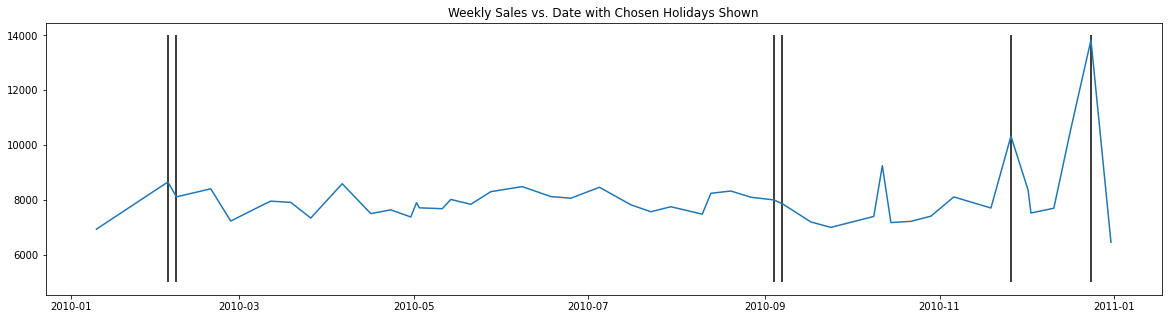

In [ ]:
#groupby date
df_average_sales_week = df_merged.groupby(by=['Date'], as_index=False)['Weekly_Sales'].median()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

#plotting
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
#vertical lines for chosen holidays
plt.vlines(x=df_merged[df_merged['IsHoliday_4'] == True]['Date'].unique(), ymin=5000, ymax=14000, color='black')
plt.title('Weekly Sales vs. Date with Chosen Holidays Shown')
plt.show()

We use the groupby function to group the data according to the date and get the dates' corresponding median weekly sales. We used the median because the median is more robust to potential outliers.

In [ ]:
total_sales_by_date_df = df_merged.groupby('Date')['Weekly_Sales'].median()
total_sales_by_date_df.head()

Date
2010-01-10    6940.74
2010-02-04    8658.89
2010-02-07    8117.29
2010-02-19    8411.25
2010-02-26    7235.80
Name: Weekly_Sales, dtype: float64

We create a bar chart for our own holidays.

Text(0, 0.5, 'Median Weekly Sales')

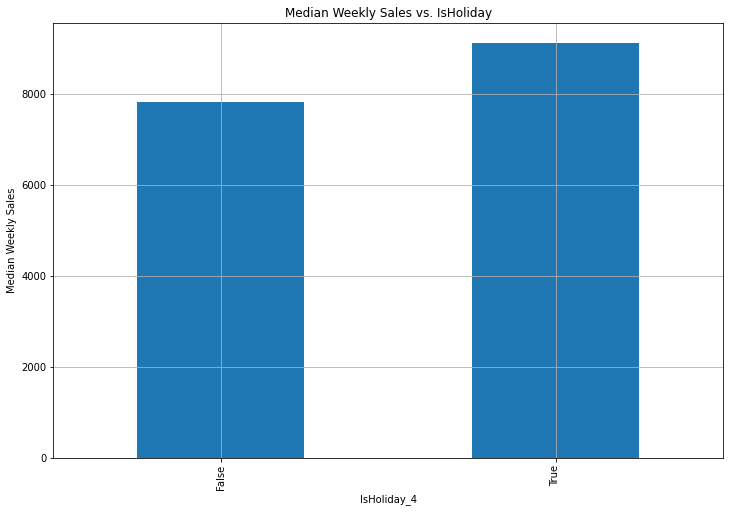

In [ ]:
ax_totalsales_isholiday = total_sales_by_isholiday_df.plot(kind='bar', grid=True, title='Median Weekly Sales vs. IsHoliday', figsize=(12,8))
ax_totalsales_isholiday.set_ylabel('Median Weekly Sales')

In [ ]:
def make_boxplot(x, y, title):
  fig, ax = plt.subplots(figsize=(15, 8))
  fig = sns.boxplot(x=x, y=y, data=df_merged, showfliers=False).set_title(title)

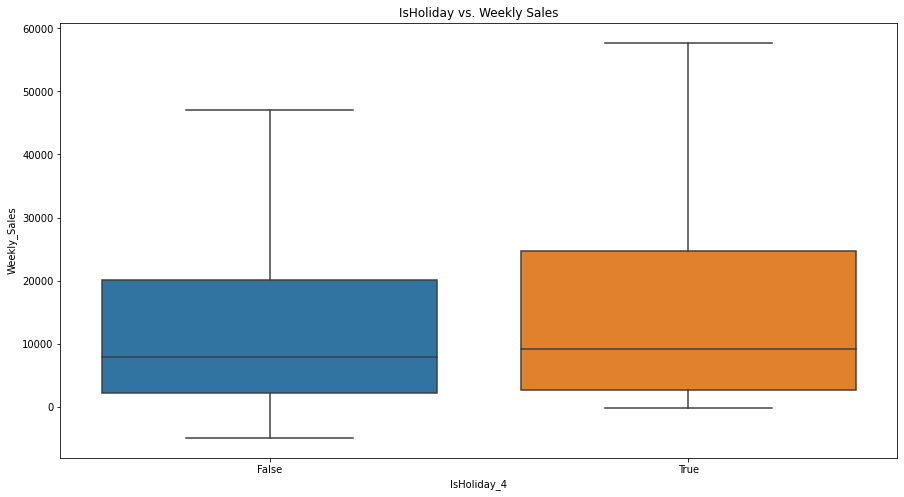

In [ ]:
make_boxplot(x='IsHoliday_4', y='Weekly_Sales', title='IsHoliday vs. Weekly Sales')

There is a bigger difference in median weekly sales here, but we wanted to explore this farther.

# Creating New Columns

We created new columns, including the month, day, and year, to make it easier to analyze our holidays.

In [ ]:
df_merged['month']= df_merged['Date'].dt.month
df_merged['day']= df_merged['Date'].dt.day
df_merged['year']= df_merged['Date'].dt.year
df_merged.head()

Store  Dept       Date  Weekly_Sales  ...  IsHoliday_4  month  day  year
0      1     1 2010-05-02      24924.50  ...        False      5    2  2010
1      1     1 2010-12-02      46039.49  ...        False     12    2  2010
2      1     1 2010-02-19      41595.55  ...        False      2   19  2010
3      1     1 2010-02-26      19403.54  ...        False      2   26  2010
4      1     1 2010-05-03      21827.90  ...        False      5    3  2010

[5 rows x 17 columns]

# Graphs for Our Newly Created Holidays

We created a function to make a line graph to plot median weekly sales vs. date for all different stores and departments.

In [ ]:
#arguments are columns and title
def make_lineplot(columns, title):
  fig, ax = plt.subplots(figsize=(20, 15))

  # plot date vs weekly sales with different lines representing the "columns"
  _ = df_merged.pivot_table(index='Date', columns=columns, values='Weekly_Sales', aggfunc='median').plot(ax=ax)
  _ = plt.grid()
  _ = ax.get_legend().remove()
  _ = plt.title(title)
  _ = plt.xlabel('Date')
  _ = plt.ylabel('Weekly Sales')
  plt.show()

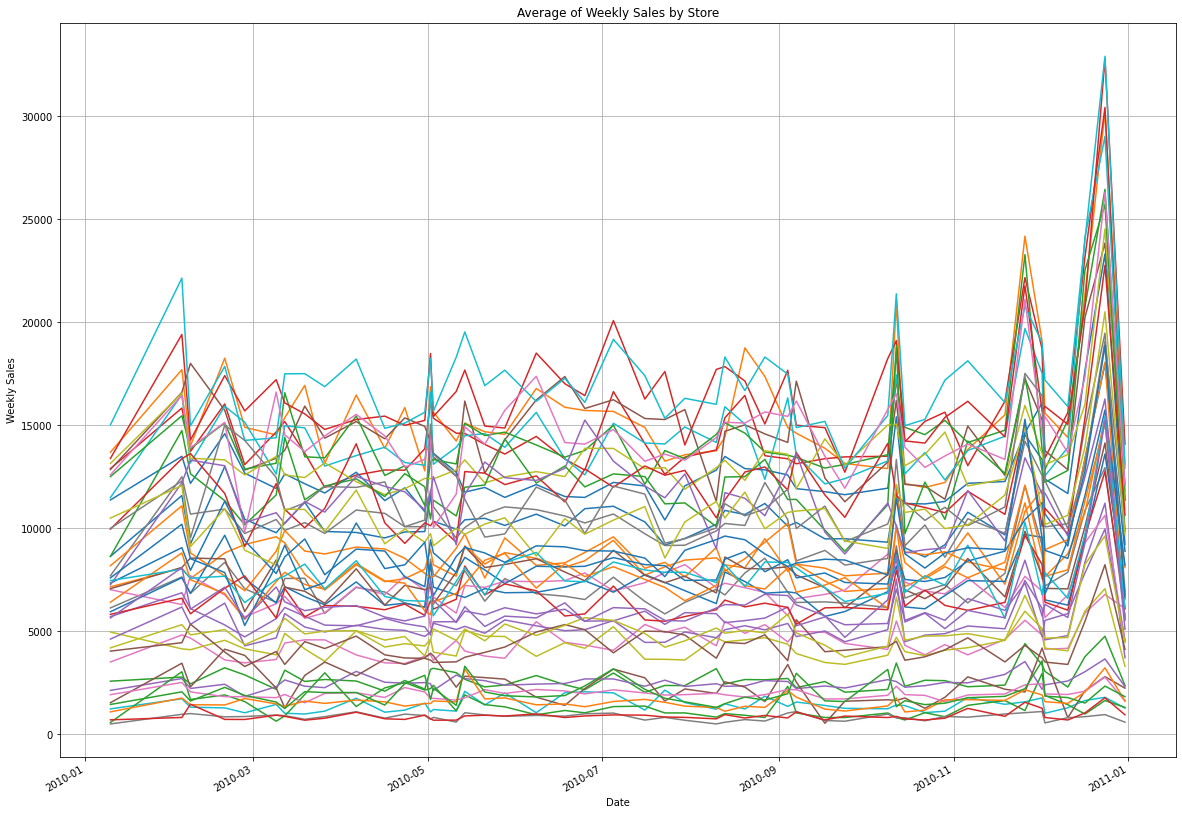

In [ ]:
make_lineplot(columns='Store', title='Average of Weekly Sales by Store')

As we can see, stores mainly differed in median weekly sales for each date, but still saw the same increases and decreases for the most part. We will zoom in on our specific holidays later on in the notebook.

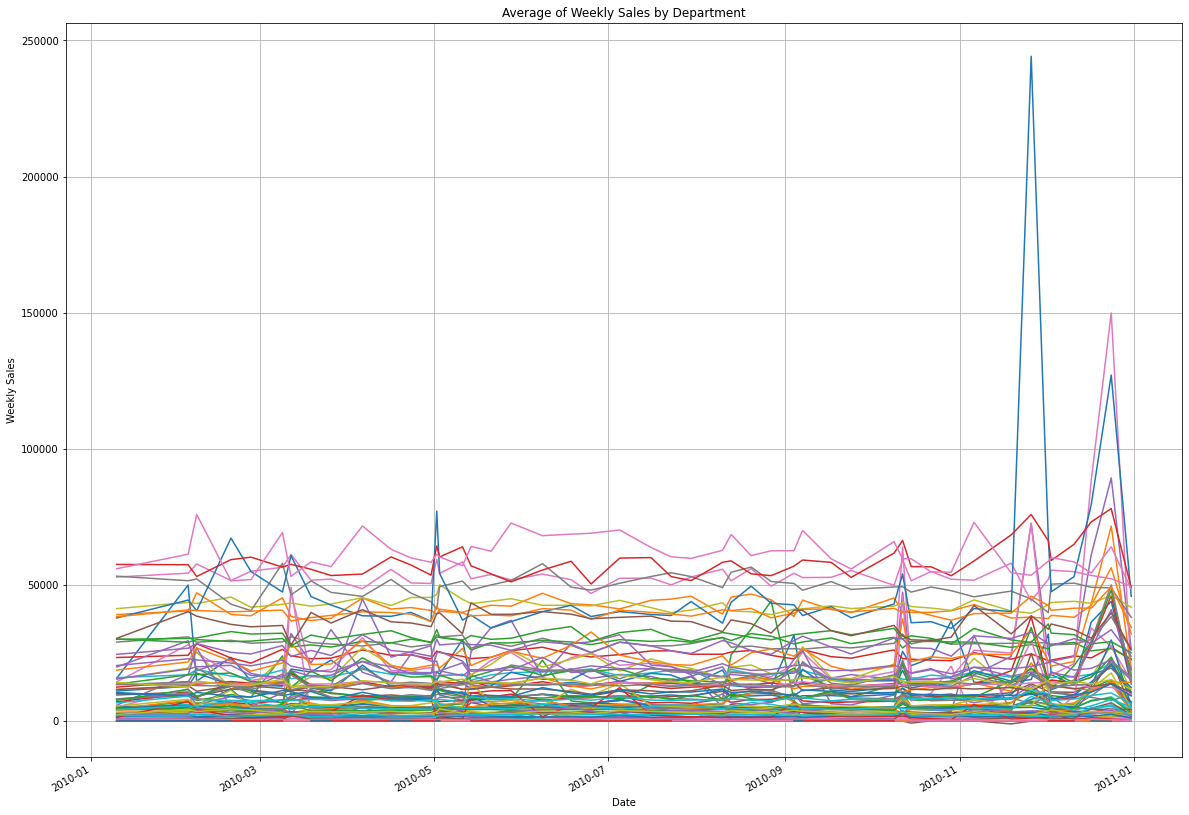

In [ ]:
make_lineplot(columns='Dept', title='Average of Weekly Sales by Department')

As we can see again, departments differed in median weekly sales. Interestingly, some departments saw huger spikes in sales during some dates.

Next we wanted to see how our new holidays along with different columns affected weekly sales. We created a function to plot this.

In [ ]:
def make_boxplot_hue(x):
  fig, ax = plt.subplots(figsize=(25, 10))
  # plot "x" versus weekly sales with the boxplots being true or false isholiday values
  fig = sns.boxplot(x=x, y='Weekly_Sales', data=df_merged, showfliers=False, hue="IsHoliday_4")

Looking at how holidays, store number, and weekly sales are related.

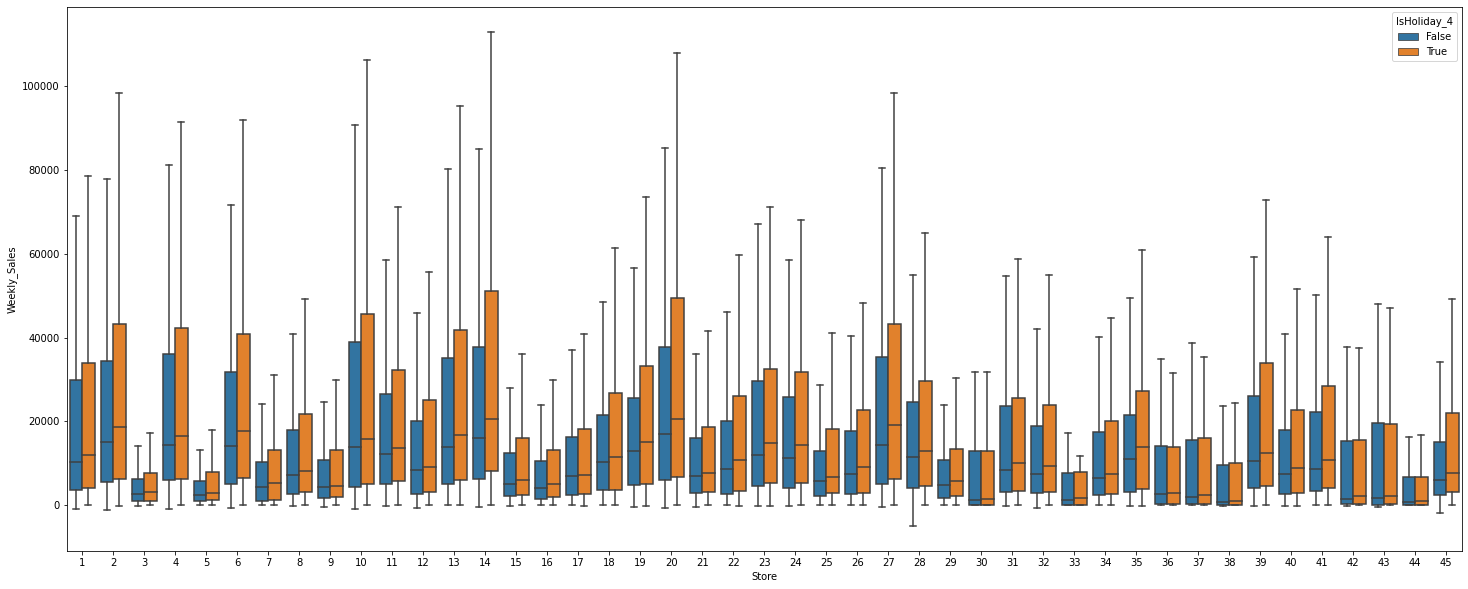

In [ ]:
make_boxplot_hue(x='Store')

As we can see, a few stores (38 and 44 for example) have no difference or very little difference in weekly sales between holidays and non-holidays. Most stores see a bigger difference, such as store 14 for example.

Next we wanted to see how department number comes into play.

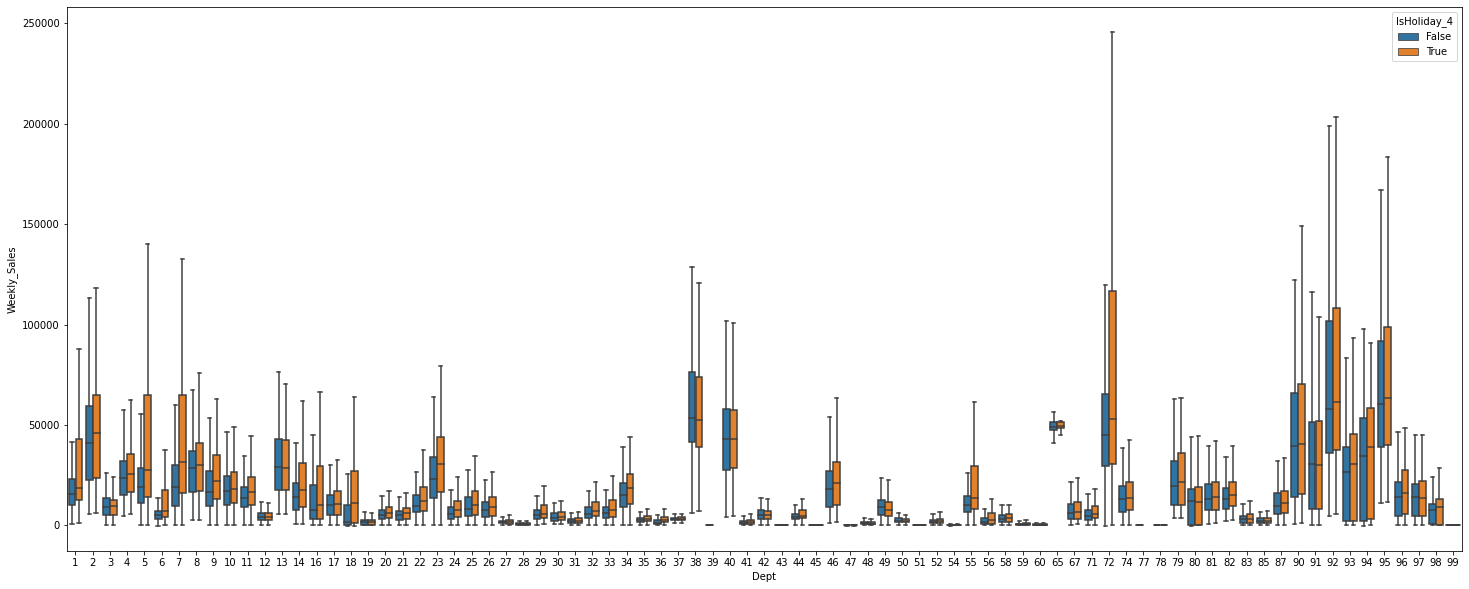

In [ ]:
make_boxplot_hue(x='Dept')

As we can see, a few departments (96 and 97 for example) have very little difference in weekly sales between holidays and non-holidays. Most departments see a bigger difference, such as department 72 or 5 for example.

Next we wanted to see it plotted monthly.

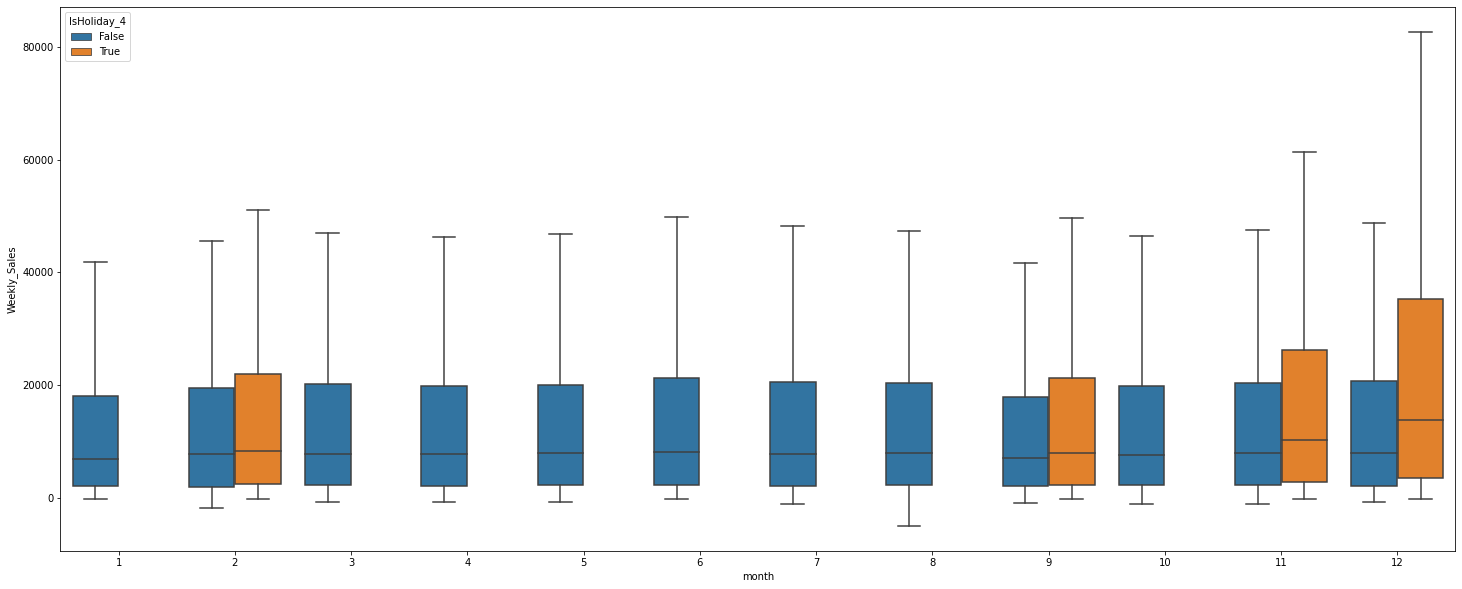

In [ ]:
make_boxplot_hue(x='month')

For the comparisons we do have, November and December see the largest differences. This is due to Thanksgiving/Black Friday and Christmas as we have seen in previous charts.

We created a new column with the date without the time stamp so when we plot this, we can easily see the dates without a bunch of zeros after them.

In [ ]:
df_merged['Date_Without_Time'] = df_merged['Date'].dt.date

We want to see how weekly sales are affected by date and our new holidays

[Text(0, 0, '2010-05-02'),
 Text(0, 0, '2010-12-02'),
 Text(0, 0, '2010-02-19'),
 Text(0, 0, '2010-02-26'),
 Text(0, 0, '2010-05-03'),
 Text(0, 0, '2010-12-03'),
 Text(0, 0, '2010-03-19'),
 Text(0, 0, '2010-03-26'),
 Text(0, 0, '2010-02-04'),
 Text(0, 0, '2010-09-04'),
 Text(0, 0, '2010-04-16'),
 Text(0, 0, '2010-04-23'),
 Text(0, 0, '2010-04-30'),
 Text(0, 0, '2010-07-05'),
 Text(0, 0, '2010-05-14'),
 Text(0, 0, '2010-05-21'),
 Text(0, 0, '2010-05-28'),
 Text(0, 0, '2010-04-06'),
 Text(0, 0, '2010-11-06'),
 Text(0, 0, '2010-06-18'),
 Text(0, 0, '2010-06-25'),
 Text(0, 0, '2010-02-07'),
 Text(0, 0, '2010-09-07'),
 Text(0, 0, '2010-07-16'),
 Text(0, 0, '2010-07-23'),
 Text(0, 0, '2010-07-30'),
 Text(0, 0, '2010-06-08'),
 Text(0, 0, '2010-08-13'),
 Text(0, 0, '2010-08-20'),
 Text(0, 0, '2010-08-27'),
 Text(0, 0, '2010-03-09'),
 Text(0, 0, '2010-10-09'),
 Text(0, 0, '2010-09-17'),
 Text(0, 0, '2010-09-24'),
 Text(0, 0, '2010-01-10'),
 Text(0, 0, '2010-08-10'),
 Text(0, 0, '2010-10-15'),
 

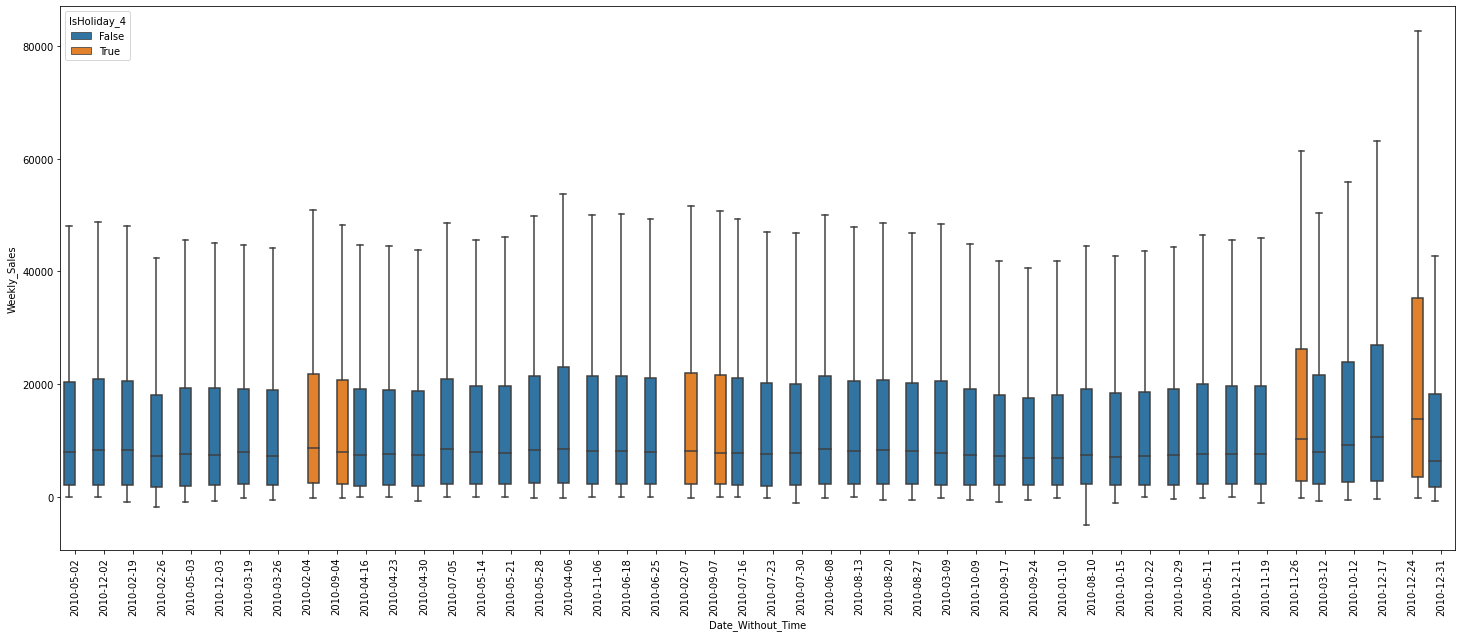

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
# plot date vs weekly sales without showing outliers
fig = sns.boxplot(x='Date_Without_Time', y='Weekly_Sales', data=df_merged, showfliers=False, hue="IsHoliday_4")
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

We can see Thanksgiving/Black Friday and Christmas have the largest spikes, as we have already seen.

Next we wanted to see how type came into play.

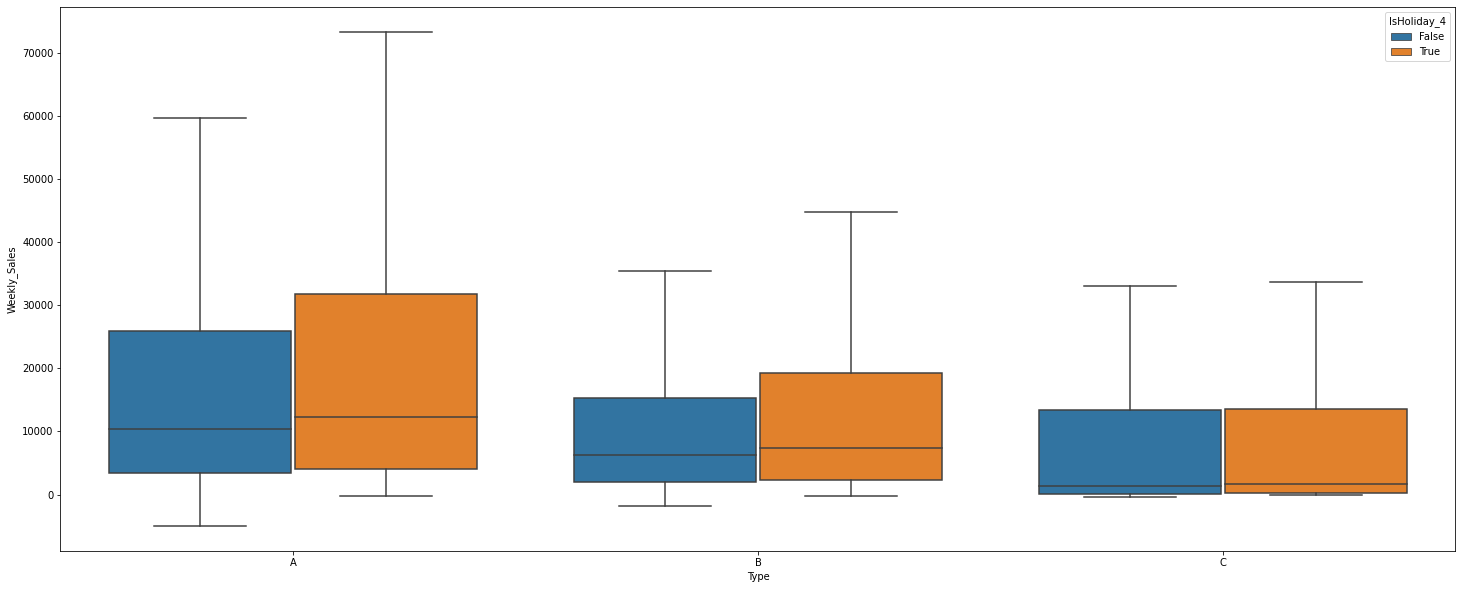

In [ ]:
make_boxplot_hue(x='Type')

Types A and B have the largest differences in sales between holidays and non holidays while Type C had relatively very little difference.

In [ ]:
df_merged.groupby(['IsHoliday_4', 'Type'])['Weekly_Sales'].median()

IsHoliday_4  Type
False        A       10395.990
             B        6254.140
             C        1308.300
True         A       12362.665
             B        7336.000
             C        1701.410
Name: Weekly_Sales, dtype: float64

We rounded these columns so the plots would be cleaner and that we could get a clearer bigger picture.

In [ ]:
df_merged['Temperature_rounded'] = df_merged['Temperature'].round(-1)
df_merged['CPI_rounded'] = df_merged['CPI'].round(0)
df_merged['Unemployment_rounded'] = df_merged['Unemployment'].round(0)
df_merged['Fuel_Price_rounded'] = df_merged['Fuel_Price'].round(1)

Seeing how unemployment came into play

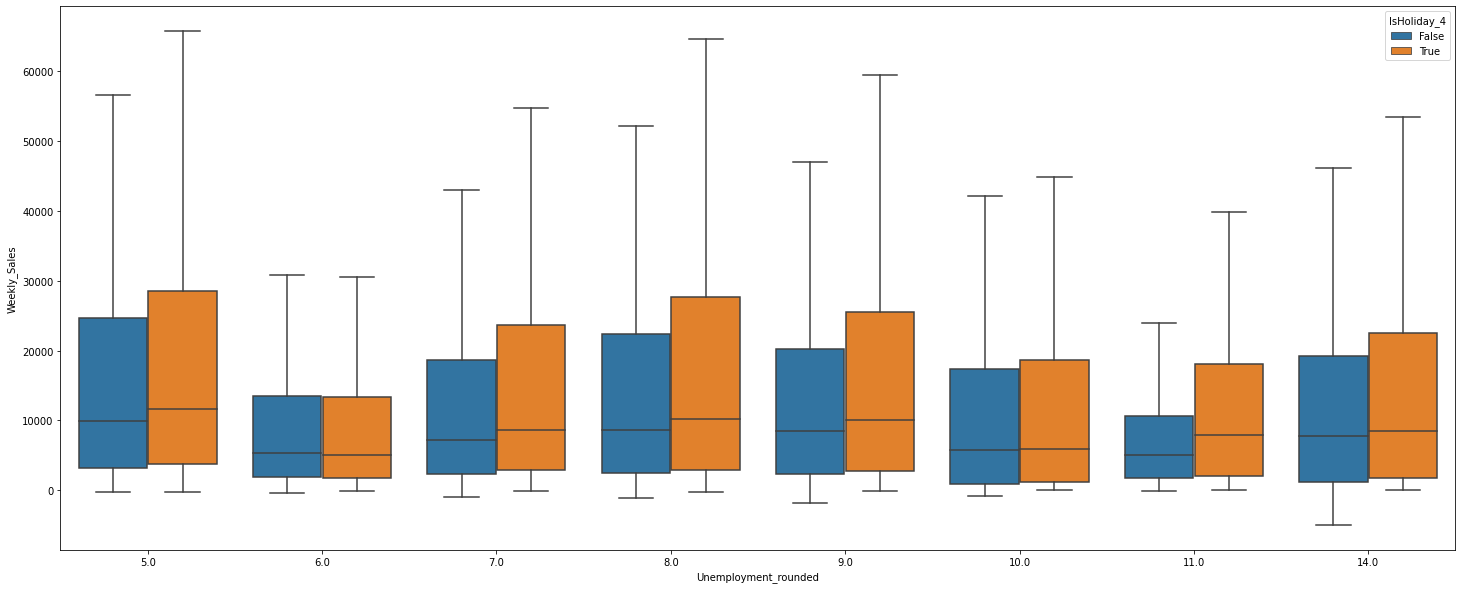

In [ ]:
make_boxplot_hue(x='Unemployment_rounded')

In [ ]:
df_merged.groupby(['IsHoliday_4', 'Unemployment_rounded'])['Weekly_Sales'].median()

IsHoliday_4  Unemployment_rounded
False        5.0                      9969.060
             6.0                      5383.335
             7.0                      7147.800
             8.0                      8584.150
             9.0                      8507.130
             10.0                     5768.850
             11.0                     5078.225
             14.0                     7790.420
True         5.0                     11592.840
             6.0                      5040.200
             7.0                      8636.490
             8.0                     10154.930
             9.0                     10075.210
             10.0                     5978.000
             11.0                     7927.255
             14.0                     8426.825
Name: Weekly_Sales, dtype: float64

We can see weekly sales are going to be higher in general for when it is a holiday regardless of the unemployment rate.

Seeing how CPI comes into play next

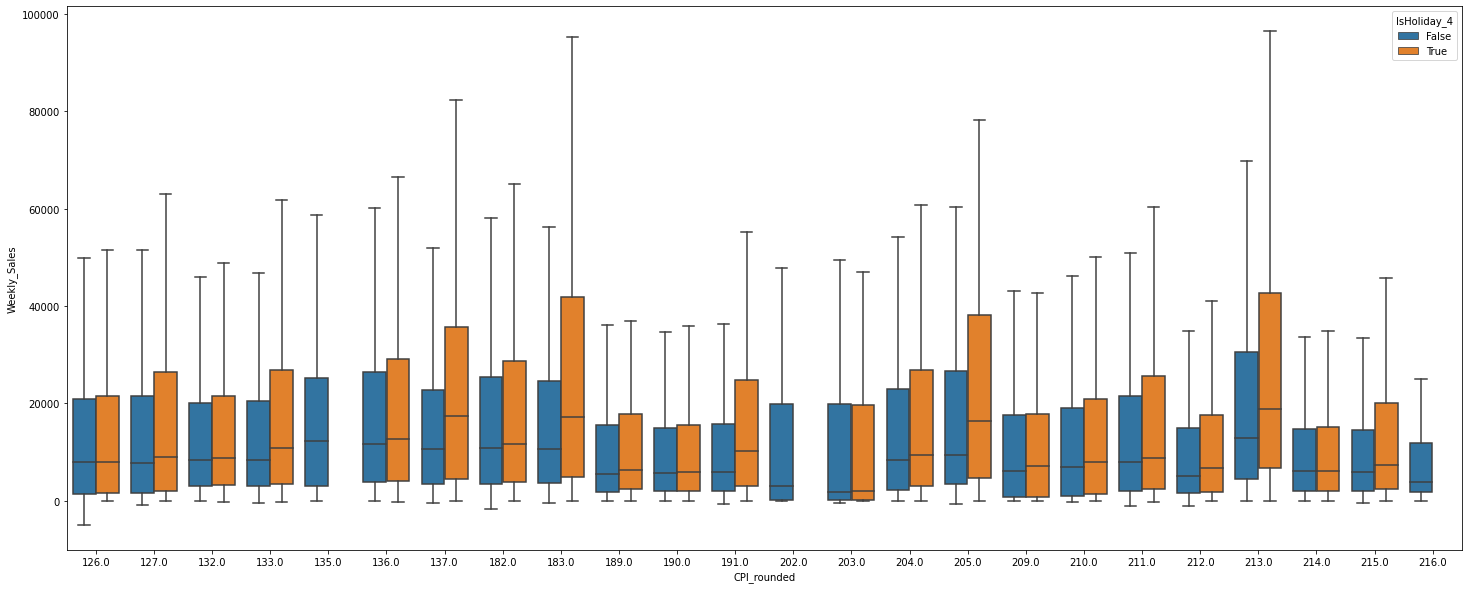

In [ ]:
make_boxplot_hue(x='CPI_rounded')

In [ ]:
df_merged.groupby(['IsHoliday_4', 'CPI_rounded'])['Weekly_Sales'].median()

IsHoliday_4  CPI_rounded
False        126.0           7934.050
             127.0           7859.270
             132.0           8482.000
             133.0           8357.675
             135.0          12203.845
             136.0          11760.690
             137.0          10726.460
             182.0          10878.890
             183.0          10581.785
             189.0           5561.535
             190.0           5666.890
             191.0           5862.925
             202.0           3029.400
             203.0           1856.835
             204.0           8458.730
             205.0           9349.480
             209.0           6102.610
             210.0           7016.130
             211.0           8003.240
             212.0           5132.995
             213.0          12916.450
             214.0           6152.400
             215.0           5885.665
             216.0           3908.690
True         126.0           8074.990
             127.0       

There's a little bit more variation here as to whether or not holidays are going to have higher weekly sales depending on the CPI. Generally speaking, weekly sales are going to be higher during holidays regardless of CPI.

Next up is temperature

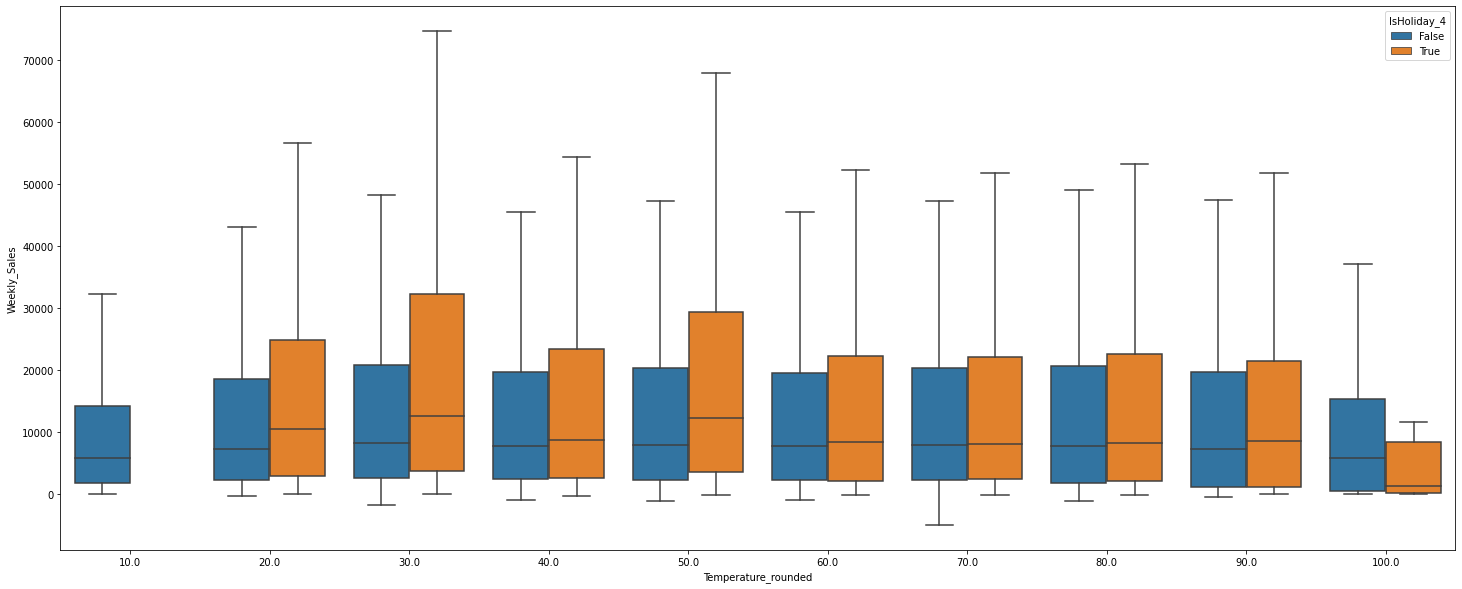

In [ ]:
make_boxplot_hue(x='Temperature_rounded')

In [ ]:
df_merged.groupby(['IsHoliday_4', 'Temperature_rounded'])['Weekly_Sales'].median()

IsHoliday_4  Temperature_rounded
False        10.0                    5776.920
             20.0                    7259.160
             30.0                    8343.510
             40.0                    7769.380
             50.0                    8014.370
             60.0                    7757.980
             70.0                    7983.895
             80.0                    7799.820
             90.0                    7235.215
             100.0                   5843.525
True         20.0                   10589.460
             30.0                   12665.455
             40.0                    8722.855
             50.0                   12260.260
             60.0                    8371.035
             70.0                    8051.320
             80.0                    8199.915
             90.0                    8544.485
             100.0                   1288.100
Name: Weekly_Sales, dtype: float64

Weekly sales are generally going to be higher for holidays regardless of temperature.

Next up is fuel price

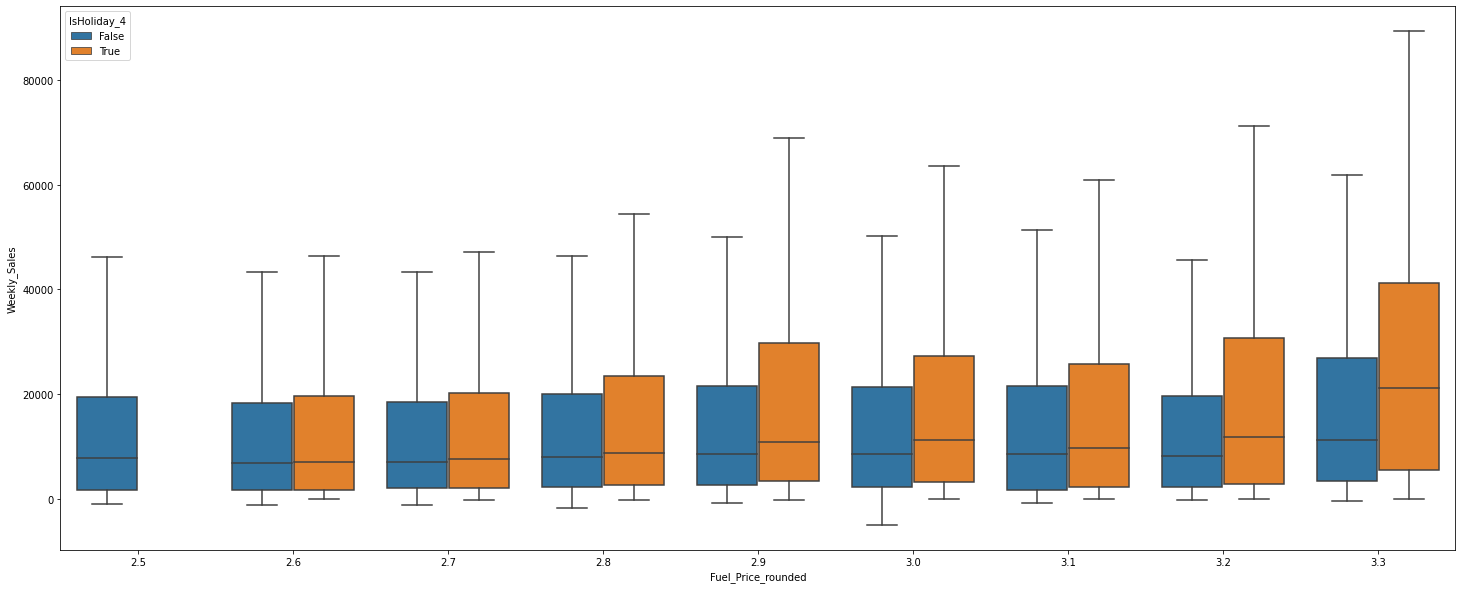

In [ ]:
make_boxplot_hue(x='Fuel_Price_rounded')

In [ ]:
df_merged.groupby(['IsHoliday_4', 'Fuel_Price_rounded'])['Weekly_Sales'].median()

IsHoliday_4  Fuel_Price_rounded
False        2.5                    7840.700
             2.6                    6914.185
             2.7                    7132.990
             2.8                    7935.355
             2.9                    8578.450
             3.0                    8685.770
             3.1                    8652.465
             3.2                    8172.000
             3.3                   11276.300
True         2.6                    7010.490
             2.7                    7598.460
             2.8                    8722.005
             2.9                   10812.700
             3.0                   11354.250
             3.1                    9780.000
             3.2                   11791.930
             3.3                   21167.680
Name: Weekly_Sales, dtype: float64

Again, we can come to a similar result.

# Correlation

We wanted to check the R values to see the relationship between a variable and weekly sales.

In [ ]:
df_merged.dtypes

Store                            int64
Dept                             int64
Date                    datetime64[ns]
Weekly_Sales                   float64
IsHoliday                         bool
Temperature                    float64
Fuel_Price                     float64
CPI                            float64
Unemployment                   float64
Type                            object
Size                             int64
day of week                     object
Week_Number                      int64
IsHoliday_4                       bool
month                            int64
day                              int64
year                             int64
Date_Without_Time               object
Temperature_rounded            float64
CPI_rounded                    float64
Unemployment_rounded           float64
Fuel_Price_rounded             float64
dtype: object

We used a label encoder to assign specific integer values to categorical values in our non numerical columns

In [ ]:
df_encoded = df_merged.copy()

In [ ]:
nonnum_columns = ['IsHoliday_4', 'Type']

In [ ]:
for c in nonnum_columns:
    if df_encoded[c].dtype == object:
        try:
            le = LabelEncoder()
            le.fit(df_encoded[c].unique())
            df_encoded[c + "_encoded"] = le.transform(df_encoded[c])
        except Exception as e:
            print(c)
            print(e)

In [ ]:
le = LabelEncoder()
le.fit(df_encoded['Date'].unique())
df_encoded['Date_encoded'] = le.transform(df_encoded['Date'])

In [ ]:
df_encoded.corr()

Store      Dept  ...  Type_encoded  Date_encoded
Store                 1.000000  0.028525  ...      0.223174      0.001275
Dept                  0.028525  1.000000  ...      0.007558     -0.001071
Weekly_Sales         -0.082301  0.132190  ...     -0.179151      0.025719
IsHoliday            -0.000244 -0.000111  ...     -0.000326      0.381323
Temperature          -0.039650  0.006488  ...      0.045026     -0.095296
Fuel_Price            0.145022  0.006118  ...      0.085836      0.187466
CPI                  -0.209652 -0.009631  ...     -0.065588      0.004582
Unemployment          0.206916  0.014152  ...      0.170863     -0.007555
Size                 -0.178624 -0.006799  ...     -0.813046     -0.001624
Week_Number           0.001241 -0.001061  ...     -0.000527      0.998735
IsHoliday_4          -0.000213  0.000530  ...      0.000110      0.046194
month                 0.001181 -0.001037  ...     -0.000492      0.995354
day                   0.000768 -0.000361  ...     -0.000472      0.113311
year                       NaN       NaN  ...           NaN           NaN
Temperature_rounded  -0.040427  0.006396  ...      0.047163     -0.084550
CPI_rounded          -0.209766 -0.009669  ...     -0.065870      0.004576
Unemployment_rounded  0.208491  0.014029  ...      0.180207     -0.005925
Fuel_Price_rounded    0.146012  0.005812  ...      0.082649      0.171436
Type_encoded          0.223174  0.007558  ...      1.000000     -0.000521
Date_encoded          0.001275 -0.001071  ...     -0.000521      1.000000

[20 rows x 20 columns]

This section was kinda just for fun. The main point is that IsHoliday and Weekly Sales have a low R value. We plotted these earlier anyway to try to gain insight about what kind of relationship they had.

# Super Bowl Analysis 


Start by taking a generous range of dates around the day of superbowl Febuary 7th 2010. This is so we can get an overview of what spending looks like.

In [ ]:
super_bowl_df= df_merged[df_merged['Date'].between("2010-01-10", "2010-02-20")]

Although the data frame has over eleven thousand entries, those weekly sales data are all spread over just four dates within our range. These dates are seen below. 

In [ ]:
super_bowl_df['Date'].unique()

array(['2010-02-19T00:00:00.000000000', '2010-02-04T00:00:00.000000000',
       '2010-02-07T00:00:00.000000000', '2010-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

Using these dates we can get an idea of what sales looked like
- In January before the superbowl
- The week leading up tp the superbowl
- The week of the superbowl
- A week later in Febuary after the superbowl

In [ ]:
sales_with_date_df = super_bowl_df.groupby('Date')['Weekly_Sales']

Create a Box Graph for our four dates to better analyze weekly sales.

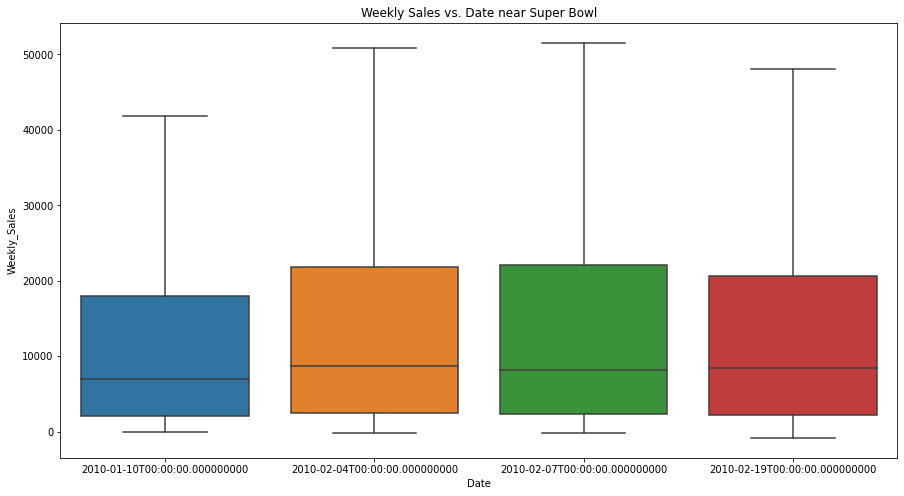

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig = sns.boxplot(x='Date', y='Weekly_Sales', data = super_bowl_df, showfliers=False).set_title('Weekly Sales vs. Date near Super Bowl')

We now want to look specifically at the median of the sales reported for dates in range

In [ ]:
sales_by_date_df = super_bowl_df.groupby('Date')['Weekly_Sales'].median()
sales_by_date_df.head()

Date
2010-01-10    6940.74
2010-02-04    8658.89
2010-02-07    8117.29
2010-02-19    8411.25
Name: Weekly_Sales, dtype: float64

When were the highest sales reported?

In [ ]:
	df_average_sales.loc[df_average_sales['Weekly_Sales'].idxmax()]

Date            2010-12-24 00:00:00
Weekly_Sales                13832.3
Name: 46, dtype: object

There isn't a huge difference. The highest median weekly sales differs by only about 200 from the second highest and 600 from the third highest. These are small amounts when looking at sales in retail stores.

Plot graph to compare weekly sales between stores and departments 

In [ ]:
def make_lineplot_sb(columns, title):
  fig, ax = plt.subplots(figsize=(20, 15))

  _ = super_bowl_df.pivot_table(index='Date', columns=columns, values='Weekly_Sales', aggfunc='median').plot(ax=ax)
  _ = plt.grid()
  _ = ax.get_legend().remove()
  _ = plt.title(title)
  _ = plt.xlabel('Date')
  _ = plt.ylabel('Weekly Sales')
  plt.show()

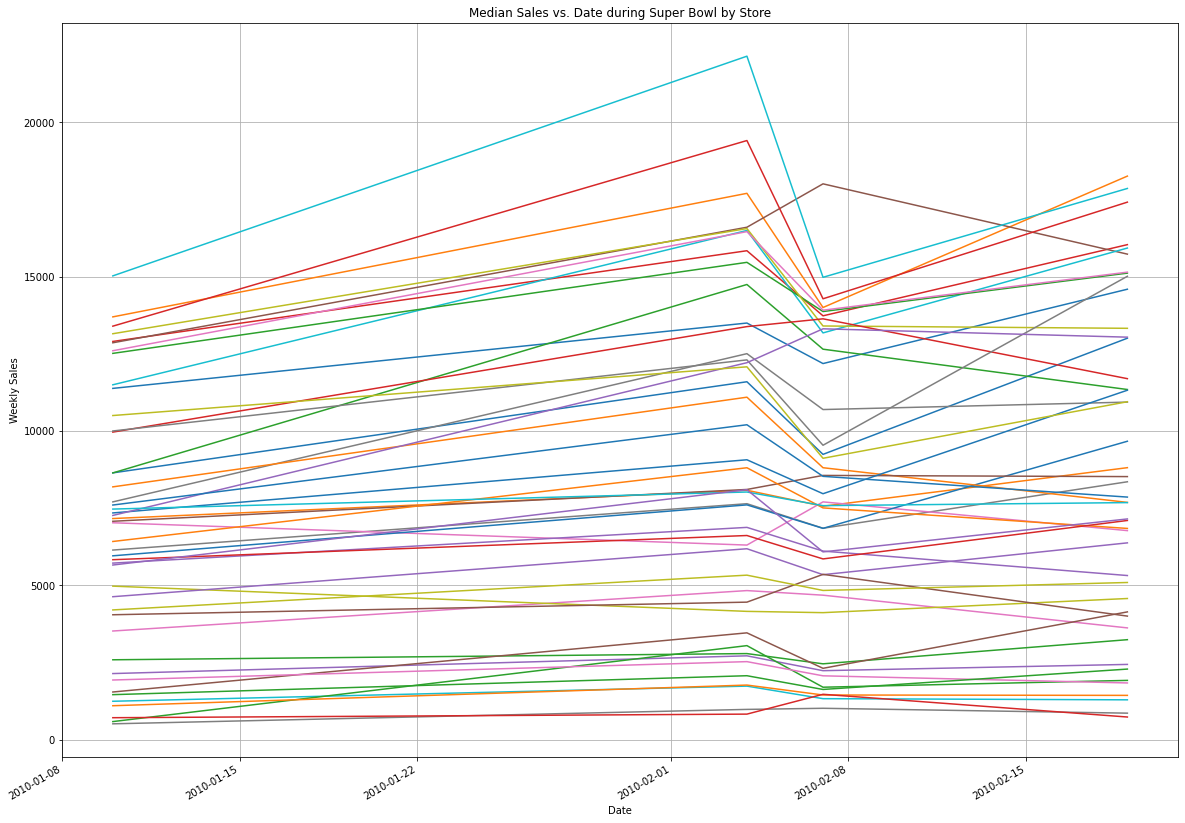

In [ ]:
make_lineplot_sb(columns='Store', title='Median Sales vs. Date during Super Bowl by Store')

As we can see, stores differed in the median weekly sales but most saw a small spike around February 4. Some peaked Super Bowl day.

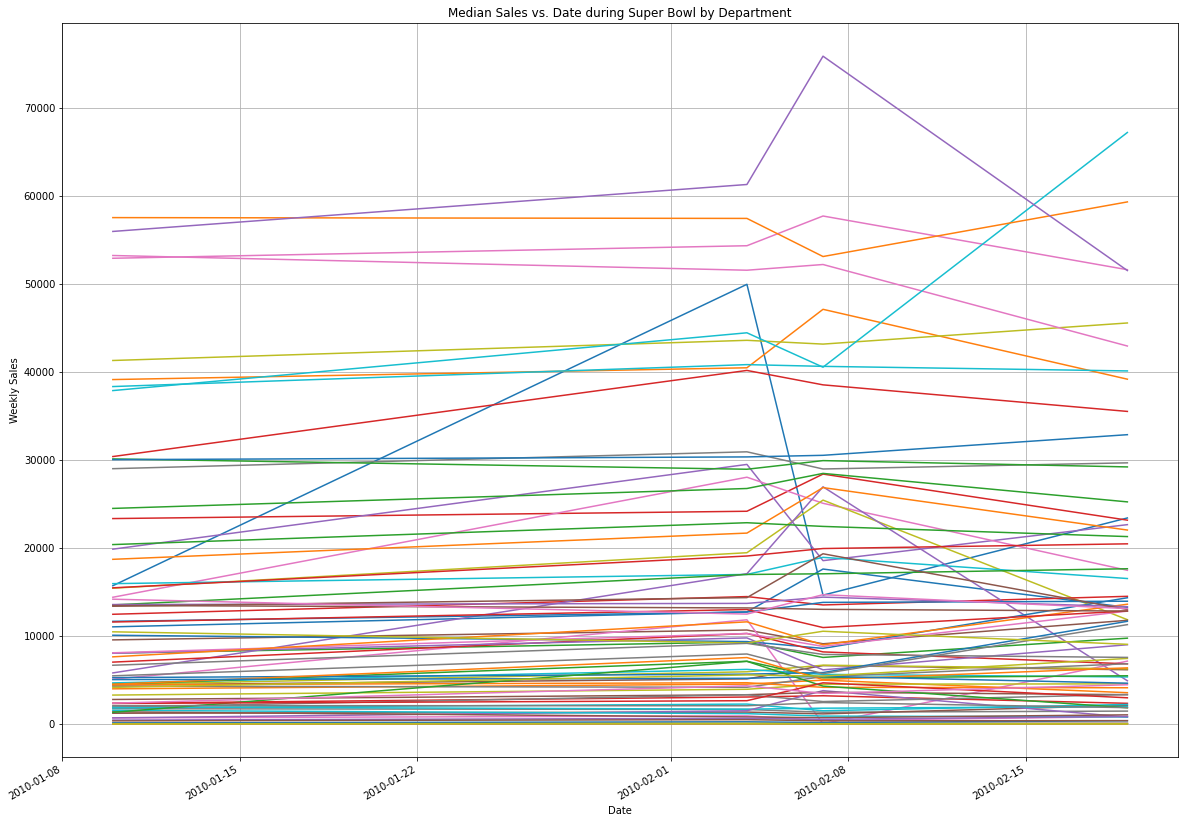

In [ ]:
make_lineplot(columns='Dept', title='Median Sales vs. Date during Super Bowl by Department')

As we can see, one department in particular sees a large spike in sales while others just see relatively small spikes or none at all.

In [ ]:
def make_boxplot_hue_sb(x, title):
  fig, ax = plt.subplots(figsize=(25, 10))
  fig = sns.boxplot(x=x, y='Weekly_Sales', data=super_bowl_df, showfliers=False, hue="IsHoliday_4").set_title(title)

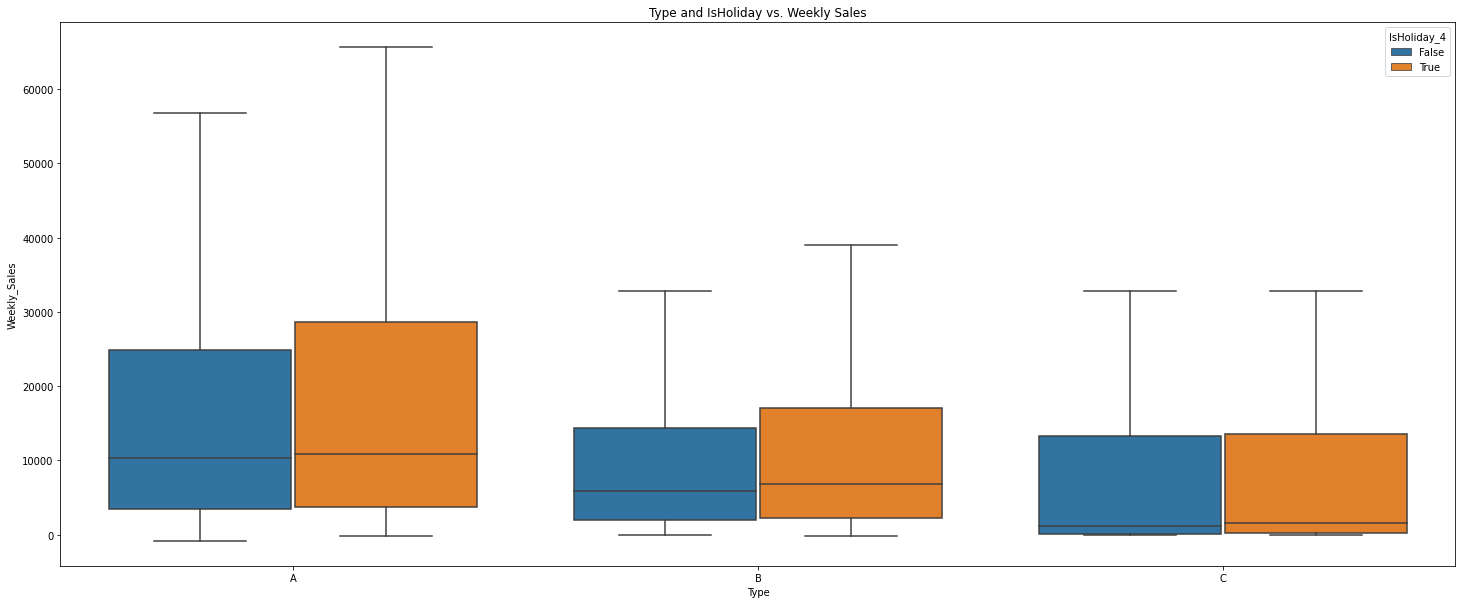

In [ ]:
make_boxplot_hue_sb(x='Type',title='Type and IsHoliday vs. Weekly Sales')

Type C had the smallest difference in sales during this date range.

# Labor Day Analysis

Start by taking a range of dates around the day of superbowl September 6th 2010. 

In [ ]:
labor_day= df_merged[df_merged['Date'].between("2010-08-16", "2010-09-27")]
labor_day.shape

(17514, 22)

The weekly sales data are all spread over just six dates within our range. These dates are seen below.

In [ ]:
labor_day['Date'].unique()

array(['2010-09-04T00:00:00.000000000', '2010-09-07T00:00:00.000000000',
       '2010-08-20T00:00:00.000000000', '2010-08-27T00:00:00.000000000',
       '2010-09-17T00:00:00.000000000', '2010-09-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

Using these dates we can get an idea of what sales looked like

- In August before Labor Day
- The weeks leading up to Labor Day
- The week of Labor Day
- Weeks in September after Labor Day

Look at results using a box plot

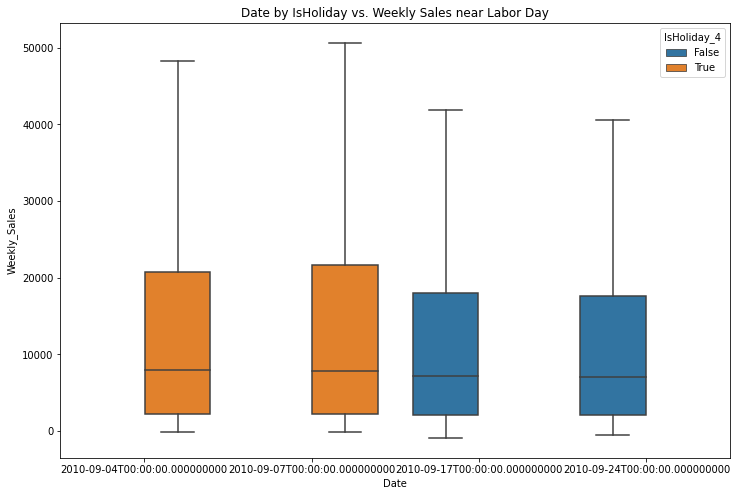

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=labor_day.Date, y='Weekly_Sales', data=labor_day, showfliers=False, hue='IsHoliday_4').set_title('Date by IsHoliday vs. Weekly Sales near Labor Day')

We can see there isn't much of a difference but now we will look up actual median values for weekly sales to see.

Looking specifically at the median of the sales reported for dates in range.

In [ ]:
sales_labor = labor_day.groupby('Date')['Weekly_Sales'].median()
sales_labor.head()

Date
2010-09-04    8006.270
2010-09-07    7867.660
2010-09-17    7202.980
2010-09-24    7005.195
Name: Weekly_Sales, dtype: float64

Counting Labor Day range.

In [ ]:
labor_day['Date'].value_counts()

2010-09-04    2951
2010-09-24    2932
2010-09-17    2929
2010-09-07    2903
Name: Date, dtype: int64

We make line graphs to see how store and department affect weekly sales near labor day.

In [ ]:
def make_lineplot_ld(columns, title):
  fig, ax = plt.subplots(figsize=(20, 15))

  _ = labor_day.pivot_table(index='Date', columns=columns, values='Weekly_Sales', aggfunc='median').plot(ax=ax)
  _ = plt.grid()
  _ = ax.get_legend().remove()
  _ = plt.title(title)
  _ = plt.xlabel('Date')
  _ = plt.ylabel('Weekly Sales')
  plt.show()

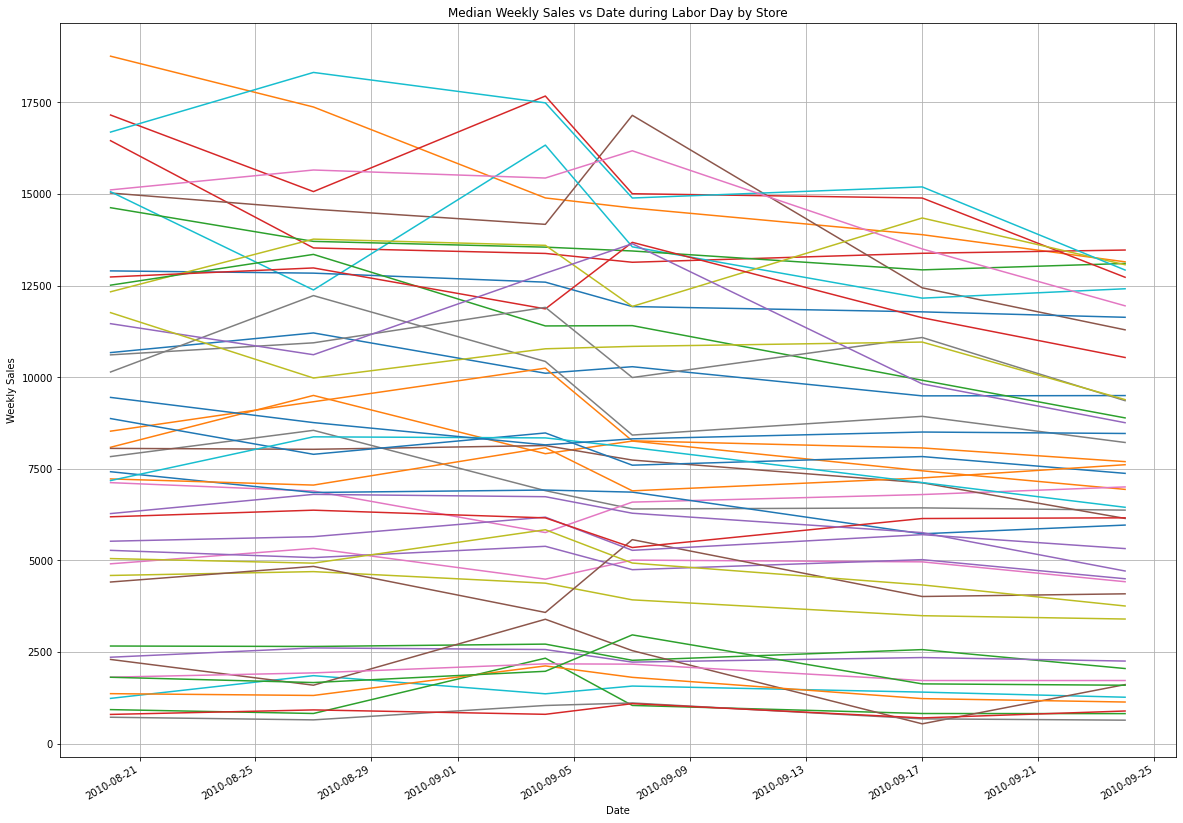

In [ ]:
make_lineplot_ld(columns='Store', title='Median Weekly Sales vs Date during Labor Day by Store')

Some see a spike and some see a plummet.

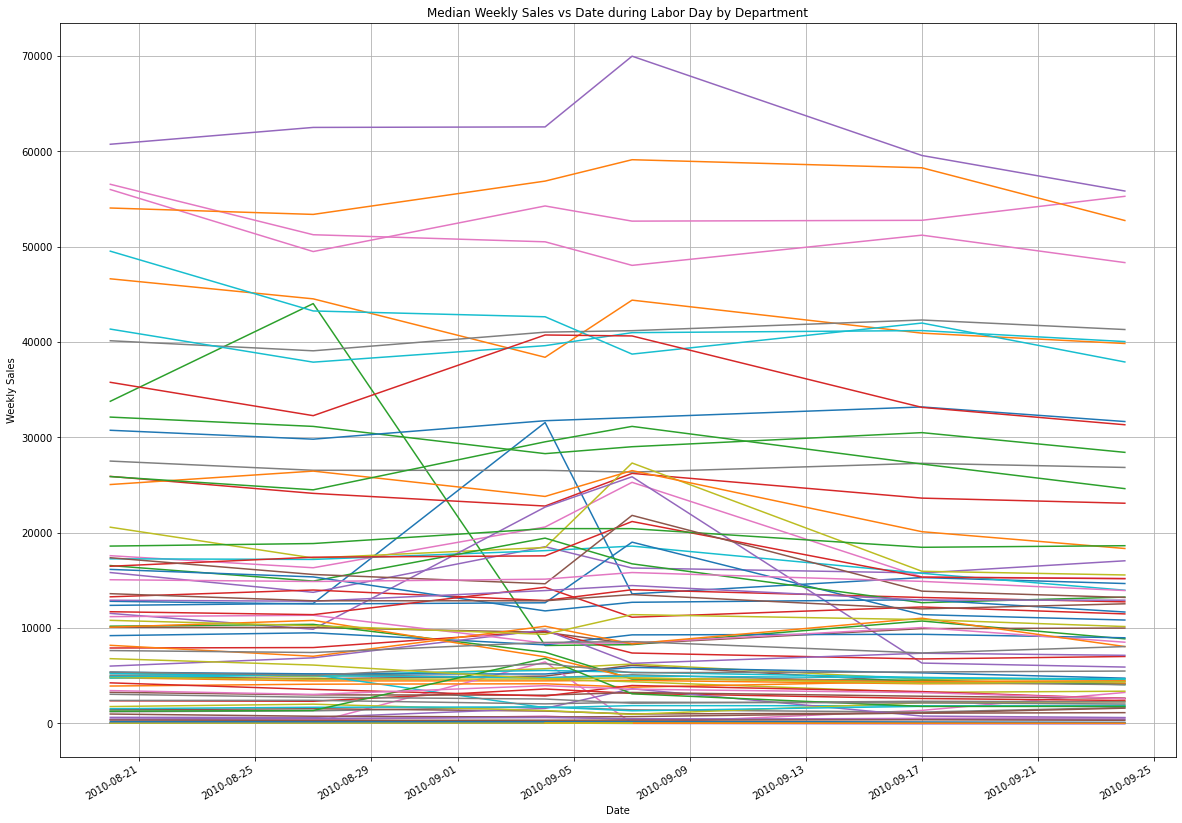

In [ ]:
make_lineplot_ld(columns='Dept', title='Median Weekly Sales vs Date during Labor Day by Department')

Some see an increase and some see a decrease.

In [ ]:
def make_boxplot_hue_l(x, title):
  fig, ax = plt.subplots(figsize=(25, 10))
  fig = sns.boxplot(x=x, y='Weekly_Sales', data=labor_day, showfliers=False, hue="IsHoliday_4").set_title(title)

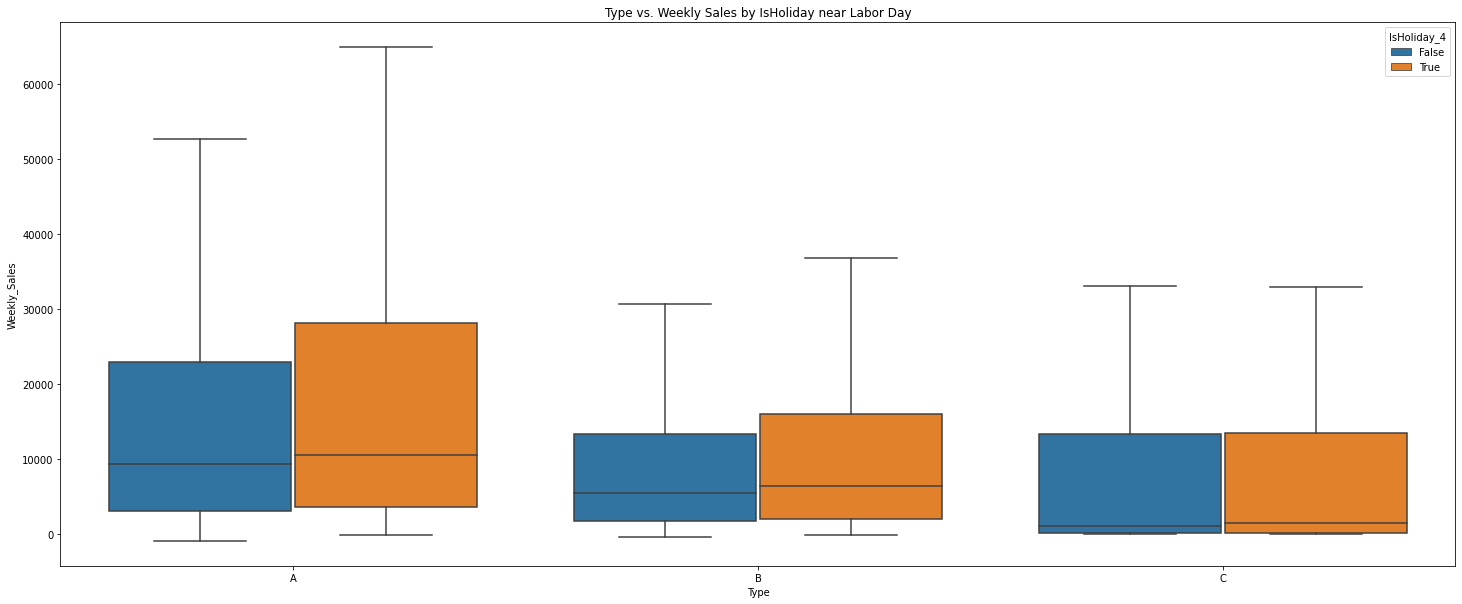

In [ ]:
make_boxplot_hue_l(x='Type', title='Type vs. Weekly Sales by IsHoliday near Labor Day')

Type C had very little difference if any in sales in this date range

# Thanksgiving/Black Friday Analysis

Start by taking a generous range of dates around the day of thanksgiving/black friday November 26, 2010. This is so we can get an overview of what spending looks like.

In [ ]:
thanksgiving = df_merged[df_merged['Date'].between('2010-11-01', '2010-12-10')]

In [ ]:
thanksgiving['Date'].unique()

array(['2010-12-02T00:00:00.000000000', '2010-12-03T00:00:00.000000000',
       '2010-11-06T00:00:00.000000000', '2010-11-19T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000'], dtype='datetime64[ns]')

Using these dates we can get an idea of what sales looked like
- In November before Thanksgiving week
- The week leading up to Thanksgiving week
- The week of Thanksgiving
- A week later in December
- Two weeks later

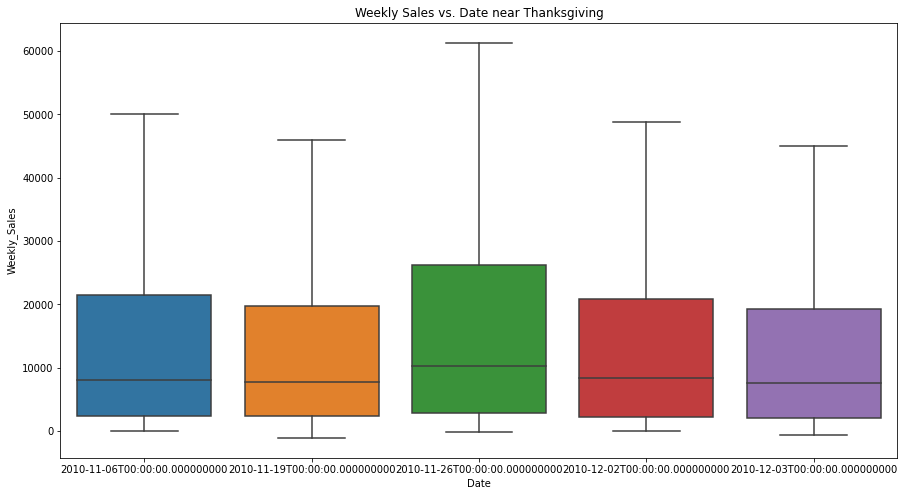

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig = sns.boxplot(x='Date', y='Weekly_Sales', data = thanksgiving, showfliers=False).set_title('Weekly Sales vs. Date near Thanksgiving')

In [ ]:
sales_by_date_df3 = thanksgiving.groupby('Date')['Weekly_Sales'].median()
sales_by_date_df3.head()

Date
2010-11-06     8114.880
2010-11-19     7711.740
2010-11-26    10328.435
2010-12-02     8365.095
2010-12-03     7529.550
Name: Weekly_Sales, dtype: float64

Median weekly sales jump about 2500 the week of Thanksgiving and then decrease.

We again make line graphs to see how store number and department come into play

In [ ]:
def make_lineplot(columns, title):
  fig, ax = plt.subplots(figsize=(20, 15))

  _ = thanksgiving.pivot_table(index='Date', columns=columns, values='Weekly_Sales', aggfunc='median').plot(ax=ax)
  _ = plt.grid()
  _ = ax.get_legend().remove()
  _ = plt.title(title)
  _ = plt.xlabel('Date')
  _ = plt.ylabel('Weekly Sales')
  plt.show()

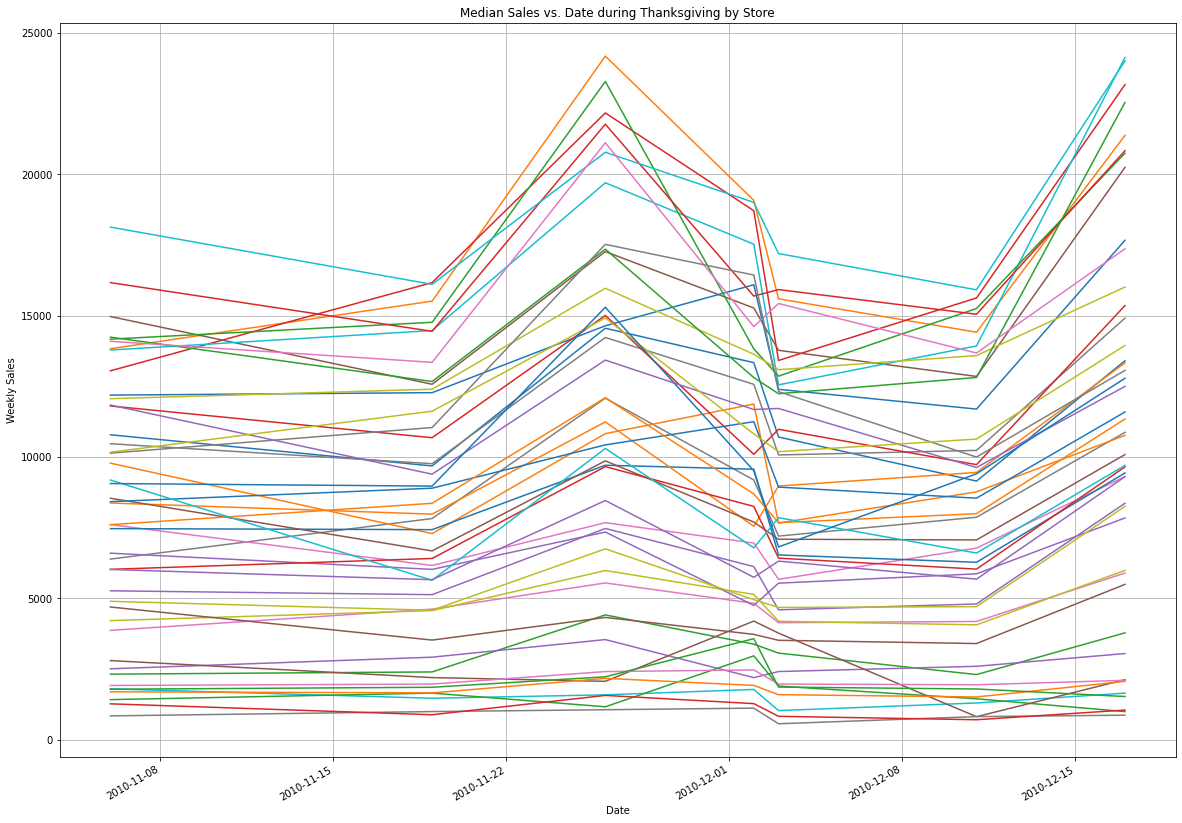

In [ ]:
make_lineplot(columns='Store', title='Median Sales vs. Date during Thanksgiving by Store')

We can see most stores see an increase in sales. Interestingly, some stores see a small decrease.

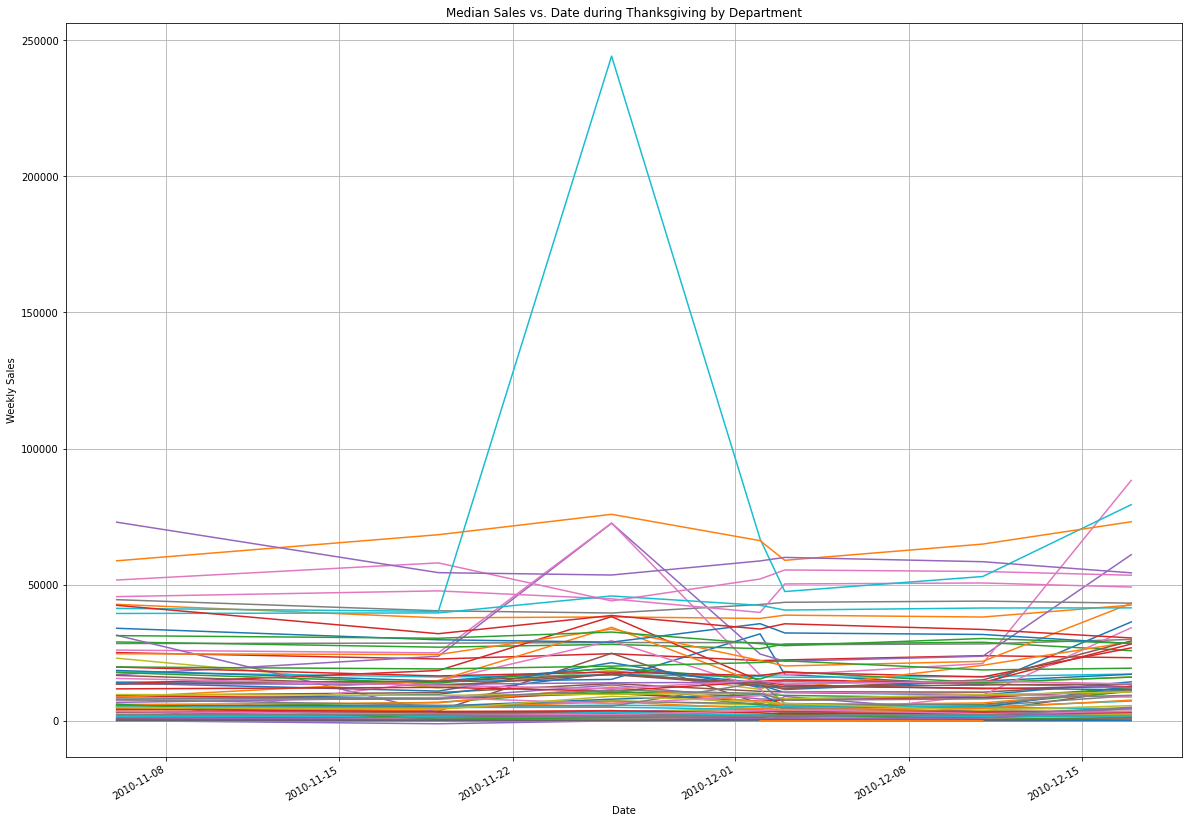

In [ ]:
make_lineplot(columns='Dept', title='Median Sales vs. Date during Thanksgiving by Department')

One department in particular sees a huge spike in sales, while most others see small to none.

In [ ]:
def make_boxplot_hue_t(x, title):
  fig, ax = plt.subplots(figsize=(25, 10))
  fig = sns.boxplot(x=x, y='Weekly_Sales', data=thanksgiving, showfliers=False, hue="IsHoliday_4").set_title(title)

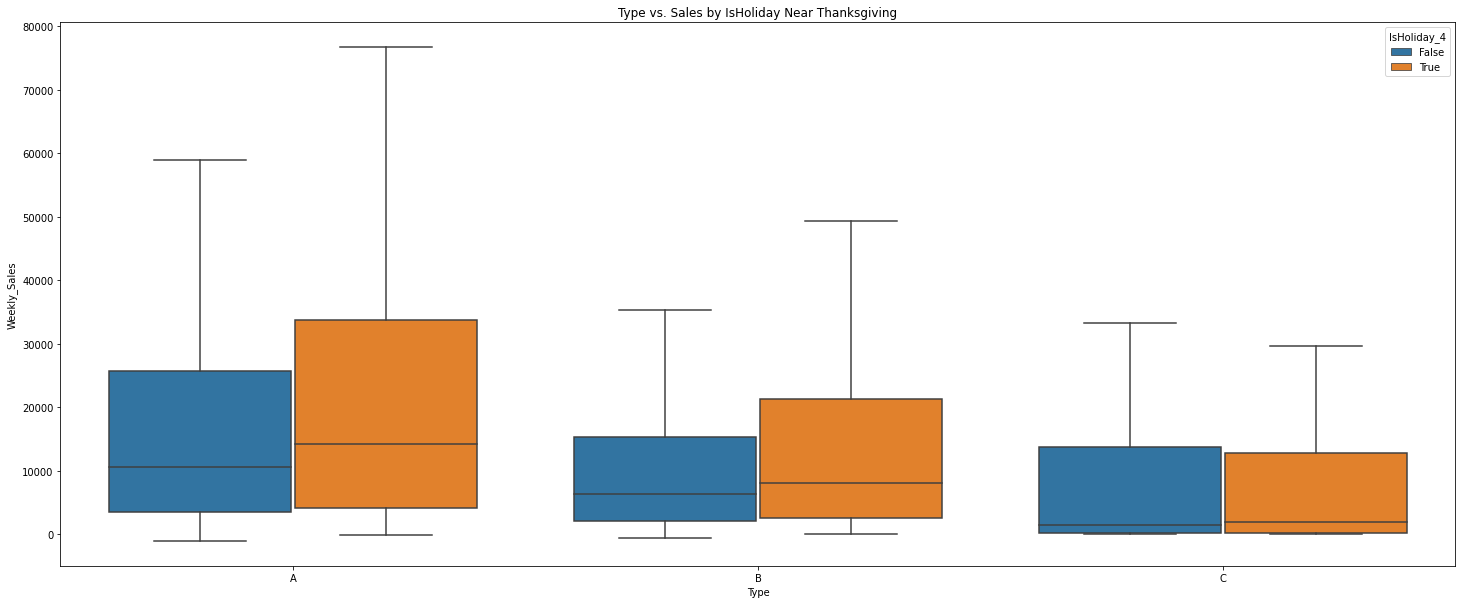

In [ ]:
make_boxplot_hue_t(x='Type', title='Type vs. Sales by IsHoliday Near Thanksgiving')

Type C actually had lower sales during thanksgiving week.

# Christmas Analysis

Start by taking a range of dates around the day of Chritmas December 25th 2010. 

In [ ]:
christmas_3weeks= df_merged[df_merged['Date'].between("2010-12-04", "2011-01-15")]
christmas_3weeks.shape

(11786, 22)

The weekly sales data are all spread over just four dates within our range. These dates are seen below.

In [ ]:
christmas_3weeks['Date'].unique()

array(['2010-12-11T00:00:00.000000000', '2010-12-17T00:00:00.000000000',
       '2010-12-24T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

Using these dates we can get an idea of what sales looked like
- The beginning of December
- The weeks leading up to Christmas
- The week of Christmas
- The week after Christmas


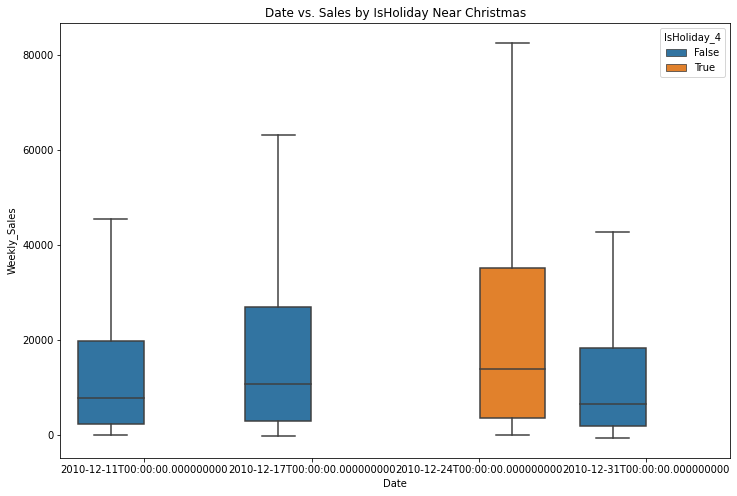

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x='Date', y='Weekly_Sales', data=christmas_3weeks, showfliers=False, hue='IsHoliday_4').set_title('Date vs. Sales by IsHoliday Near Christmas')

In [ ]:
christmas_sales=christmas_3weeks.groupby('Date')['Weekly_Sales'].median()
christmas_sales.head()

Date
2010-12-11     7703.435
2010-12-17    10614.750
2010-12-24    13832.275
2010-12-31     6462.160
Name: Weekly_Sales, dtype: float64

Median weekly sales increased by about 3000 during Christmas week.

Counting Christmas range

In [ ]:
christmas_3weeks['Date'].value_counts()

2010-12-17    2959
2010-12-24    2956
2010-12-31    2943
2010-12-11    2928
Name: Date, dtype: int64

We again make line graphs to see how store number and department come into play

In [ ]:
def make_lineplot_c(columns, title):
  fig, ax = plt.subplots(figsize=(20, 15))

  _ = christmas_3weeks.pivot_table(index='Date', columns=columns, values='Weekly_Sales', aggfunc='median').plot(ax=ax)
  _ = plt.grid()
  _ = ax.get_legend().remove()
  _ = plt.title(title)
  _ = plt.xlabel('Date')
  _ = plt.ylabel('Weekly Sales')
  plt.show()

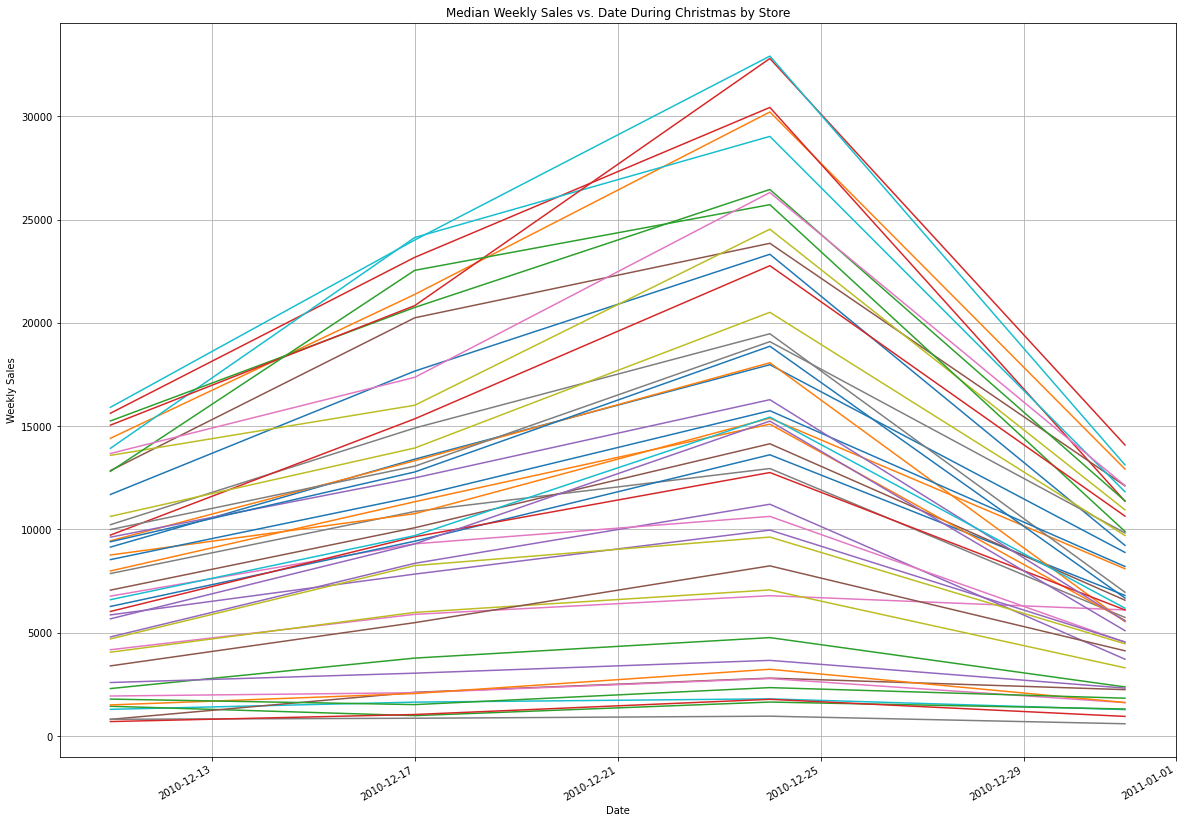

In [ ]:
make_lineplot_c(columns='Store', title='Median Weekly Sales vs. Date During Christmas by Store')

Most stores see a huge peak the week of Christmas.

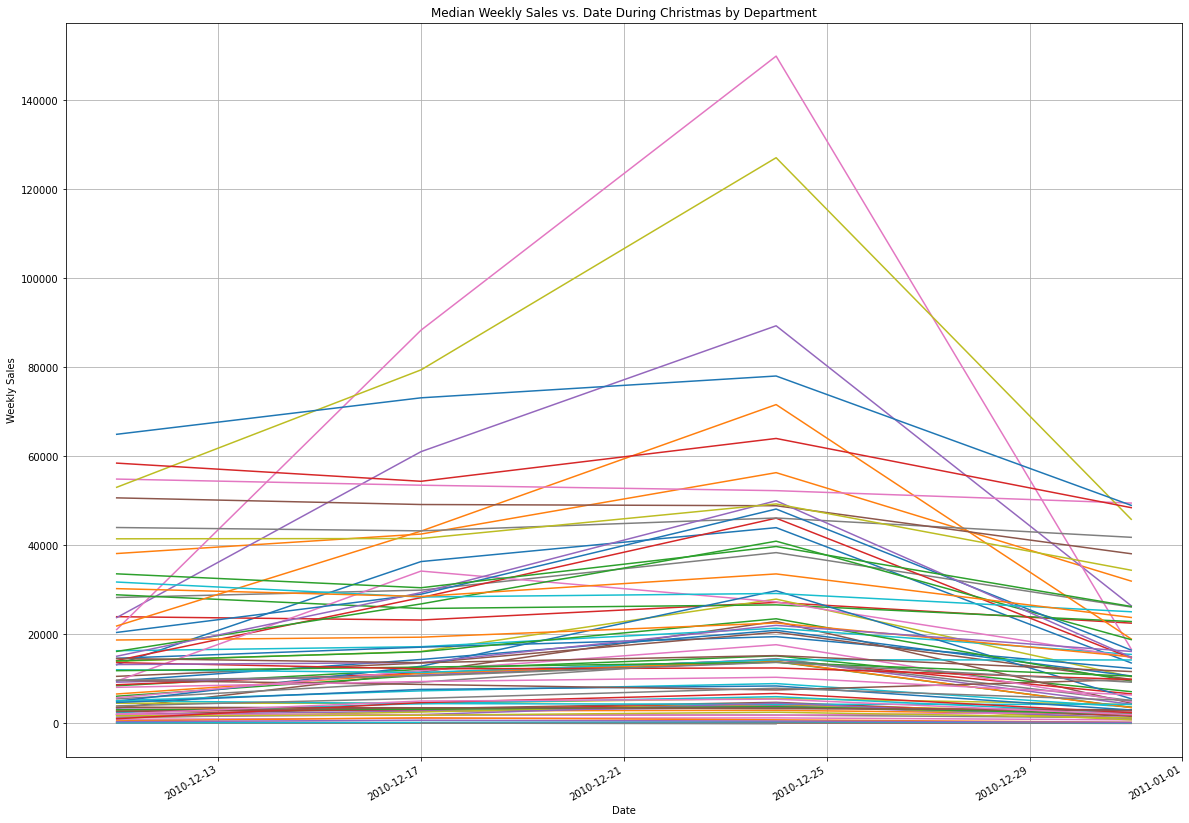

In [ ]:
make_lineplot_c(columns='Dept', title='Median Weekly Sales vs. Date During Christmas by Department')

Some departments see no change while others experience large peaks.

In [ ]:
def make_boxplot_hue_c(x, title):
  fig, ax = plt.subplots(figsize=(25, 10))
  fig = sns.boxplot(x=x, y='Weekly_Sales', data=christmas_3weeks, showfliers=False, hue="IsHoliday_4").set_title(title)

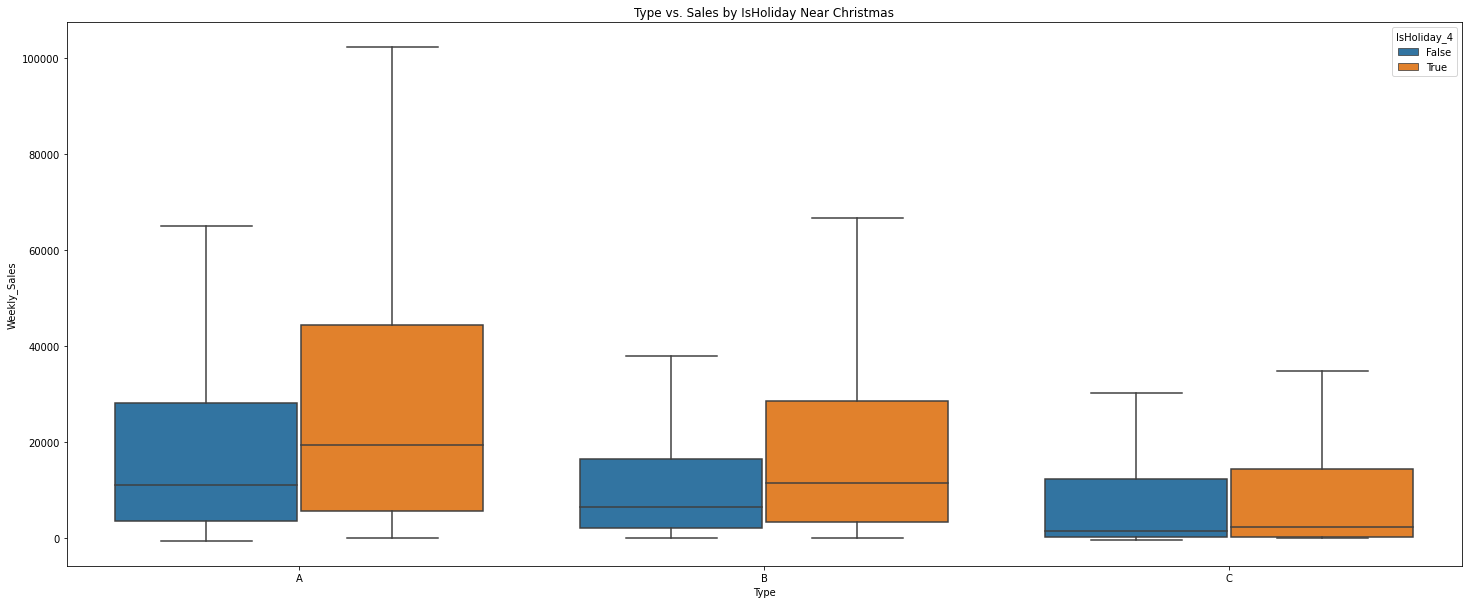

In [ ]:
make_boxplot_hue_c(x='Type', title='Type vs. Sales by IsHoliday Near Christmas')

Type C had the smallest difference in sales for this date range

# Summing It Up

While we did see that there were peaks in sales corresponding to certain holidays, we wanted to explore this further than plotting IsHoliday and Weekly Sales. We saw that type C had the smallest difference between weekly sales during holidays and non holidays while types a and b had bigger differences. We saw that unemployent, CPI, fuel price, and temperature had little effect on weekly sales based on whether or not it was a holiday. Moreover, we saw variation in weekly sales based on departments and stores in some cases. 